# Intelligent Systems for Bioinformatics


#### Mariana Coelho, Mónica Fernandes  and Tiago Machado 

### Phase 1


## Initial Exploration 

As part of the course Intelligent Systems for Bioinformatics, we were **challenged** to classify phenotypes from omics data.
This analysis involves using machine learning algorithms, supervised and unsupervised, to perform this classification automatically.

The suggested dataset consists of a set of **32 studies** on **stress responses in rice** (*Oryza sativa*) using gene expression data from microarrays on a single platform, *AffymetrixRiceArray*.
These studies focused on a variety of stresses to which the rice plants were exposed, generally classified as "**biotic**" and "**abiotic**" stresses. In total, of the **32 studies** analyzed, **13** refer to **abiotic** conditions while **17** refer to **biotic** conditions.
The goal of our work is to use this abundance of transcriptomic data to **predict**, from a given microarray profile, the **exposure** of the plant to **biotic** or **abiotic** stresses.

The starting point for the analysis of these data is the work of *Shaik & Ramakrishna, 2014 (DOI:10.1104/PP.113.225862)*. The authors worked on these same data and performed a **meta-analysis** separately on the data referring to **biotic and abiotic stresses** to identify the **differentially expressed genes** between the two types of stress.
The authors identified a set of **1377 differentially expressed genes** common to both **biotic** and **abiotic** stresses.

This work was then used as a **feature selection** to retain the **variables of interest** for our analysis.

| Stress type | Studies | Samples |
| --- | --- | --- |
| Bacteria | 7 | 227 |
| Cold | 2 | 19 |
| Drought | 6 | 84 |
| Fungus | 4 | 41 |
| Heat Shock | 1 | 6 |
| Insect | 2 | 21 |
| Metal | 3 | 42 |
| Nematode | 2 | 15 |
| Nutrient | 1 | 10 |
| Salt | 4 | 50 |
| Submergence | 1 | 8 |
| Virus | 1 | 12 |
| Weed | 1 | 24 |
| **Total** | **35** | **559** |

The table above shows the microarray experiments whose data are used in this work. Of the **35 studies** indicated, **32** were **used**, with **17** corresponding to **biotic stresses** and **14** to **abiotic stresses**.

In [1]:
import os
import GEOparse
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, levene, mannwhitneyu
from statsmodels.stats.weightstats import ztest as ztest
from pprint import pprint
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from numpy import mean
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from time import time

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Dataset Generation

The data used in this study were taken from the "*Gene Expression Omnibus*" (**GEO**) database.
Using the study labels provided by the authors ("**Base_data.csv**"), the data from all experiments were extracted and processed.
Each **study** consists of **sample data**, which have **replicates among themselves**.
In our approach, we **merged** the **replicates** by taking the **mean** of their **expression values**.
However, the information distinguishing the replicates from the samples is not clearly discriminated, being only available in the labels of each sample.
Since **there is no** **uniform notation** for the **sample labels**, it was necessary to carry out an **identification process** using regular expressions.

After obtaining the **samples with the means** of their replicates, these were **aggregated** with the **information** about the **study** they were associated with, and the **type of stress** considered in that study.

After obtaining this dataset, the **working dataset** was obtained by filtering the probes for the **1377 differentially expressed genes** common to both **biotic** and **abiotic** stresses indicated by the author.

In [3]:
%%script false --no-raise-error

base_data = "Base_data.csv"

def create_base_dataset(base_data):
    df = pd.read_csv(base_data, sep=",", header=0)
    ids = [id for id in df["Study"]]
    ids = list(np.unique(ids))
    GSE_ind = [gse for gse in df["Sample"]]
    descr = [des for des in df["Sample Description"]]
    stresses = [st for st in df["Stress"]]
    indx = 0
    df_total = pd.DataFrame()
    while indx != (len(ids) + 1):
        if indx == (len(ids)+1):
            break
        idx = ids[indx]
        gse = GEOparse.GEOparse.get_GEO(geo=idx, destdir="./SOFT_F")
        print("GSM")
        count = 0
        for gsm_name, gsm in gse.gsms.items():
            print("Name: ", gsm_name)
            print("Metadata:", )
            if gsm_name in GSE_ind:
                for key, value in gsm.metadata.items():
                    if key == "title":
                        name = value
                        name = str(name[0])
                        for i in range(len(descr)):
                            if name == descr[i]:
                                stress = stresses[i]
                                print(stress)
                        if ", biological" in name:
                            name = re.search(".*bio", name).group().rstrip(", bio")
                        elif " biological" in name:
                            name = re.search(".*b", name).group().rstrip(" b")
                        elif "replicate" in name:
                            name = re.search(".*rep", name).group().rstrip(" rep")
                        elif ", rep" in name:
                            name = re.search(".*rep", name).group().rstrip(", rep")
                        elif "- rep" in name:
                            name = re.search(".*rep", name).group().rstrip("- rep")
                        elif "rep" in name:
                            name = name.replace(" rep1", "").replace(" rep2", "").replace(" rep3", "").replace(" rep4",
                                                                                                               "").replace(
                                " rep 1", "").replace(" rep 2", "").replace(" rep 3", "").replace("rep 4", "")

                        elif "Rep" in name:
                            name = re.search(".*Rep", name).group().rstrip("Rep")
                        elif "-A" or "-B" in name:
                            name = name[:-2]
                        if "_1" or "_2" or "_3" in name:
                            name = re.sub("_[0-9]", "", name)
                        else:
                            m = re.findall("-[0-9]")
                            if m in name:
                                name = re.search(".*-[0-9]", name).group()
                        print(name)
                    else: continue
                    print(name)
                print("Table data:", )
                if count == 0:
                    df = gsm.table
                    df = df.assign(id_study=ids[indx])
                    df = df.assign(title=gsm_name)
                    df = df.assign(info=name)
                    df = df.assign(stress=stress)
                    count += 1
                    continue
                else:
                    df_2 = gsm.table
                    df_2 = df_2.assign(id_study=ids[indx])
                    df_2 = df_2.assign(title=gsm_name)
                    df_2 = df_2.assign(info=name)
                    df_2 = df_2.assign(stress=stress)
                    df = df.append(df_2)

        df = df.groupby(["info", "ID_REF", "id_study", "stress"]).agg({"VALUE": np.mean})
        df_total = df_total.append(df)

        indx += 1
        if indx == len(ids):
            break
        else:
            continue

    df_total.to_csv("final_dataset.csv")


create_base_dataset(base_data)

def filtering_by_degs(df_degs, df_raw):
    df_degs = pd.read_csv(df_degs, sep=",", header=0)
    df_raw = pd.read_csv(df_raw, sep=",", header=0)
    id_probe_degs = [id for id in df_degs["Probe ID"]]
    count = 0
    for id_degs in id_probe_degs:
        print()
        if count == 0:
            df_final = df_raw.loc[(df_raw["ID_REF"] == id_degs)]
            count += 1
            continue
        else:
            df_2 = df_raw.loc[(df_raw["ID_REF"] == id_degs)]
            df_final = df_final.append(df_2)
    df_final.to_csv("DEGs_final.csv")


filtering_by_degs("DEGs.csv", "final_dataset.csv")

## Univariate Analysis

### Obtaining the working dataset

To proceed with the analysis of the obtained data, the **final dataset** was processed to obtain a structure where the **dependent variables** (columns) are the **genes** and the **labels** (rows) are the **sample descriptions**. An additional column was added referring to the **type of stress** each sample was subjected to. For this, it was necessary to organize the indexes of the dataframe and the table, since their organization was different.

In [4]:
# Final dataset still in GEO format:
# needs to be modified to obtain the working dataset
df = pd.read_csv("DEGs_final.csv")
df = df.drop(df.columns[0], axis = 1)

print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

This dataset has 302940 rows and 5 columns.


In [5]:
import warnings
warnings.filterwarnings('ignore')

#Extracting stress classification ordered by sample labels
df_bio = df.drop_duplicates(subset = "info", keep = "last")
df_bio.sort_values(by = ["info"], inplace = True)

In [6]:
# Preparing the working dataset SamplesxGenes
table = pd.pivot_table(data=df, index = ["info"], columns = ["ID_REF"], values = ["VALUE"])
#Sort by sample labels
table.sort_values(by = ["info"], inplace = True)

print(f"This dataset has {table.shape[0]} samples (rows) and {table.shape[1]} genes (columns).")

This dataset has 219 samples (rows) and 1377 genes (columns).


### Normality check and normalization

In [7]:
#Normality of the data
#Check the normality of the distributions for each gene
normality = table.apply(shapiro, axis = 0).T
normal = len([x for x in normality[normality.columns[1]] if x >= 0.05]) #todas nao normais
print(normal)

0


The *Shapiro-Wilk* test was performed for all variables in the dataset (excluindo a variável independente) and it was found that **none** of the **variables** was **normally distributed**.

In [8]:
#Normalization of the data - Z-Scores

std_scale = StandardScaler()
columns_name = [x[1] for x in table.columns]
df_std = pd.DataFrame(std_scale.fit_transform(table), columns = columns_name, index = table.index)

#Add labels of the independent variable of the study "Stress"
df_std["Stress"] = df_bio["stress"].values

#Separate for univariate analysis the rows corresponding to biotic and abiotic stress
df_std_bio = df_std[df_std["Stress"] == "Bio"]
print(f"This dataset has {df_std_bio.shape[0]} samples (rows) corresponding to biotic stresses.")
df_std_abio = df_std[df_std["Stress"] == "Abio"]
print(f"This dataset has {df_std_abio.shape[0]} samples (rows) corresponding to abiotic stresses.")


#Eliminate the independent variable
df_std_bio = df_std_bio.drop(df_std_bio.columns[-1], axis=1)
df_std_abio = df_std_abio.drop(df_std_abio.columns[-1], axis=1)

This dataset has 128 samples (rows) corresponding to biotic stresses.
This dataset has 91 samples (rows) corresponding to abiotic stresses.


Using the preprocessing module from ***scikit-learn***, the ***StandardScaler*** function was used to perform **data normalization**, which was done using *z-scores*.

In [9]:
#Standardized working dataset (and save to .csv)
df_std.to_csv("Final_ds.csv")
df_std

,Os.1000.1.S1_at,Os.10003.1.S1_at,Os.10041.1.S1_at,Os.10058.1.S1_at,Os.10150.1.S1_at,Os.10166.1.S1_at,Os.10172.1.S1_at,Os.10174.1.S1_at,Os.10175.1.S1_at,Os.10197.1.S1_at,...,OsAffx.6015.1.S1_at,OsAffx.6051.1.S1_at,OsAffx.6162.1.S1_s_at,OsAffx.6386.1.S1_at,OsAffx.7086.1.S1_at,OsAffx.7294.1.S1_at,OsAffx.7566.1.S1_s_at,OsAffx.7755.1.S1_s_at,OsAffx.9883.1.S1_x_at,Stress
info,,,,,,,,,,,,,,,,,,,,,
14-day-old seedling,-0.380697,-0.513037,-0.643689,-0.143838,-0.260662,-0.338280,-0.253057,-0.290211,-0.060158,-0.424409,...,-0.206944,-0.584205,-0.428430,-0.408337,0.334059,-0.369313,-0.572254,-0.476922,-0.613522,Abio
"14-day-old seedling, heat shock",-0.328111,-0.258246,-0.365662,-0.410419,-0.068423,-0.334894,-0.225087,-0.324647,-0.652844,-0.405772,...,-0.519294,0.247016,-0.423553,-0.013297,-0.127852,-0.223635,-0.539351,-0.352660,-0.369636,Abio
144hpi with array type rice from Affymetr,-0.539672,-0.547005,-0.743713,-0.569324,-0.448934,-0.363253,-0.403355,-0.361346,-0.765580,-0.420840,...,-0.571837,-0.666600,-0.424270,-0.725917,-0.459177,-0.574212,-0.546881,-0.698694,-0.662489,Bio
48hpia with array type rice from Affymetr,-0.538607,-0.547244,-0.741028,-0.569735,-0.449691,-0.363224,-0.404361,-0.363941,-0.762653,-0.420633,...,-0.568383,-0.666874,-0.424038,-0.725923,-0.458902,-0.574340,-0.542575,-0.698685,-0.659457,Bio
48hpib with array type rice from Affymetr,-0.538250,-0.547073,-0.741281,-0.569068,-0.449714,-0.363219,-0.403506,-0.363792,-0.762869,-0.420979,...,-0.568296,-0.666868,-0.424025,-0.725901,-0.459922,-0.574339,-0.540974,-0.698673,-0.658640,Bio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rice seedling grown under Pi-sufficient condition,-0.538864,-0.214457,0.815511,1.357393,9.070474,0.052142,0.566504,3.928198,0.083342,0.270909,...,-0.460845,-0.362519,-0.412087,-0.097783,-0.090202,-0.242631,-0.559511,-0.502138,-0.584662,Abio
temoin with array type rice from Affymetr,-0.538548,-0.547114,-0.744595,-0.568179,-0.449088,-0.363246,-0.402458,-0.361032,-0.757817,-0.418872,...,-0.569243,-0.665959,-0.424265,-0.725910,-0.456918,-0.574207,-0.542497,-0.698730,-0.660617,Bio
temoina with array type rice from Affymetr,-0.538401,-0.547269,-0.742140,-0.569124,-0.449985,-0.363253,-0.405503,-0.364260,-0.757518,-0.418328,...,-0.567119,-0.666887,-0.424063,-0.725930,-0.457187,-0.574342,-0.550104,-0.698692,-0.655136,Bio


### Tests on variances and means

In [10]:
#Levene's Test
stats = []
for coluna in df_std_bio.columns:
    stat, p = levene(df_std_bio[coluna].values, df_std_abio[coluna].values)
    stats.append((stat, p))

In [11]:
#Number of genes with homogenous variance
vari_s = len([x for x in stats if x[1] < 0.05])
print(f"From the {table.shape[1]} genes, {vari_s} have homogenous variance and {table.shape[1] - vari_s} have non-homogenous variance")

From the 1377 genes, 945 have homogenous variance and 432 have non-homogenous variance


The *Levene* test was performed on all variables, **excluding the independent variable**, to test the **homogeneity of variances** of each variable with respect to its **distribution between** the **two stress classes** (independent variable). Of the **1377 genes**, it is observed that for the distributions analyzed, **945** have **homogeneous variance** and **432** have **non-homogeneous variances**.

In [12]:
#Obtain the indexes of genes with homogeneous and non-homogeneous variances through a vector of booleans
var_idx = []
for x in stats:
    if x[1] < 0.05:
        var_idx.append(True)
    else:
        var_idx.append(False)

In [13]:
#Filter datasets to retain only genes (variables) with homogeneous variances
df_vars_bio = df_std_bio[df_std_bio.columns[var_idx]]
df_vars_abio = df_std_abio[df_std_abio.columns[var_idx]]

In [14]:

#Filter datasets to retain only genes (variables) with inhomogeneous variances
var_idx_rev = [not elem for elem in var_idx]

df_varns_bio = df_std_bio[df_std_bio.columns[var_idx_rev]]
df_varns_abio = df_std_abio[df_std_abio.columns[var_idx_rev]]
# print(df_vars_abio)

In [15]:
#Perform parametric (Z-test) and nonparametric (Mann-Whitney U-test) tests to determine whether variables differ in their distribution by biotic and abiotic stresses.

#Parametric tests - genes with homogeneous variance
z_stats = []
for coluna in df_vars_bio.columns:
    stat, p = ztest(df_vars_bio[coluna].values, df_vars_abio[coluna].values)
    z_stats.append((stat, p))


z_s = len([x for x in z_stats if x[1] < 0.05])
z_ns = len([x for x in z_stats if x[1] >= 0.05])
z_total = z_s + z_ns

In [16]:
#Nonparametric tests - genes with non-homogeneous variance

mw_stats = []
for coluna in df_varns_bio.columns:
    stat, p = mannwhitneyu(df_varns_bio[coluna], df_varns_abio[coluna])
    mw_stats.append((stat, p))

mw_s = len([x for x in mw_stats if x[1] < 0.05])
mw_ns = len([x for x in mw_stats if x[1] >= 0.05])
mw_total = mw_s + mw_ns

After checking the homogeneity of variances, tests were performed on each variable to verify whether they showed **significant differences** between **biotic** and **abiotic** stresses. For variables with **homogeneous variances**, the **parametric test** called *Z-test* was used, while for variables with **non-homogeneous variances** the **non-parametric test** *Mann-Whitney-U-Test* was used.

In [17]:
#Summary dataset of Z-tests and Mann-Whitney-U-Tests
summary_df = pd.DataFrame(np.array([[z_s, mw_s, z_s+z_ns], [z_ns, mw_ns, mw_s+mw_ns], [z_total, mw_total, z_total+mw_total]]), columns= ["Significant", "Not Significant", "Total"], index=["Z-test", "Mann whitney U-test", "Total"])
summary_df

,Significant,Not Significant,Total
Z-test,908,85,945
Mann whitney U-test,37,347,432
Total,945,432,1377


From the tests performed, it is found that of the **945** variables subjected to the *Z-test*, **908** show **significant differences** between **biotic** and **abiotic** stress, while the remaining **120** show **non-significant differences**. Similarly, for the **432** variables subjected to the *Mann-Whitney* test, only **37** show **significant differences**, while **312** show **non-significant differences**. This highlights a **connection** between the **variables** with **non-homogeneous variances** and the **significance of the differences** between the **means** for the studied classes, as revealed by the non-parametric tests performed.

### Boxplots

In [18]:
#Boxplots

#Get Gene as lowest p-value of parametric tests
p_v_z = [y for x, y in z_stats]
z_min = p_v_z.index(min(p_v_z))

#Isolate gene name
z_min_col = df_vars_bio.iloc[:, z_min].name

#Get Gene as lowest p-value of nonparametric tests
p_v_mw = [y for x, y in mw_stats]
mw_min = p_v_mw.index(min(p_v_mw))
#Isolate gene name
mw_min_col = df_vars_bio.iloc[:, mw_min].name

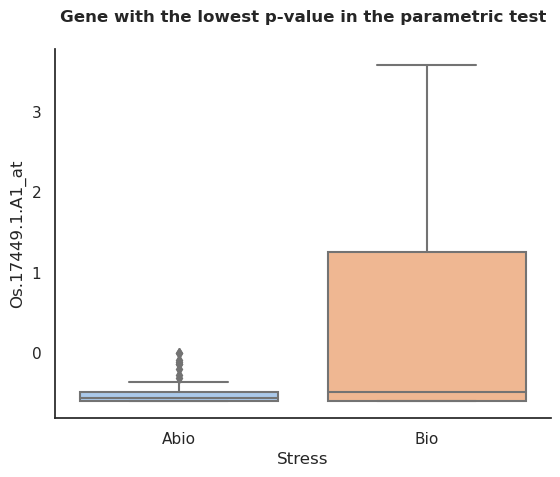

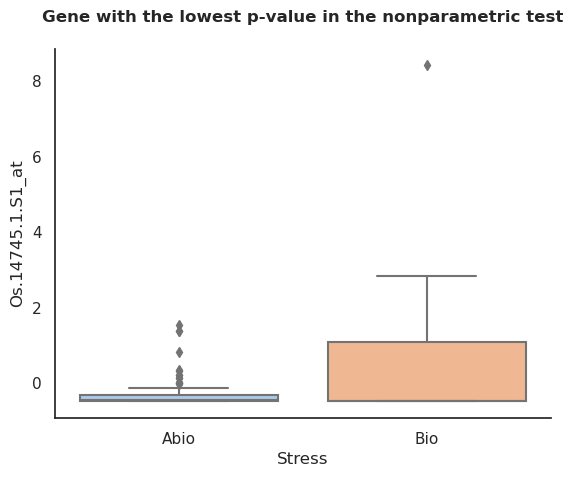

In [19]:
#Boxplots
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", palette="pastel", rc=custom_params)

#Boxplot gene with lowest p-value of parametric test
ax=sns.boxplot(y=z_min_col, x="Stress", data=df_std)
ax.set_title("Gene with the lowest p-value in the parametric test", y=1.05, fontweight='bold')
plt.show()

#Boxplot with lowest p-value of nonparametric tests
ax=sns.boxplot(y=mw_min_col, x="Stress", data=df_std)
ax.set_title("Gene with the lowest p-value in the nonparametric test", y=1.05, fontweight='bold')
plt.show()

Overexpression of the gene **Os.17449.1.A1_at**, belonging to the auxin family, is associated with periods of **nitrogen deficiency**, which corresponds to an **abiotic stress**. In turn, the gene **Os.14745.1.S1_at** is associated with the physiological process of **lignification**, and its expression changes when subjected to **biotic stresses**. Thus, we can conclude that using the methodology described above, it was possible to **isolate** genes whose expression is **relevant** for the **distinction** between biotic and abiotic stresses.

To visually represent the differences of the variables with respect to the studied classes, 2 boxplots were constructed. The **first** corresponds to the **gene** with the **lowest p-value** among the **parametric tests** and the **second** corresponds to the **gene** with the **lowest p-value** among the **non-parametric tests**. In both cases, it is possible to observe **differences** between the **distribution of the variable** with respect to the two studied classes, **validating** the tests previously performed.

### Phase 2

## Multivariate Analysis

### Correlation Analysis

Text(0.5, 1.05, 'Heatmap grouped by correlated genes')

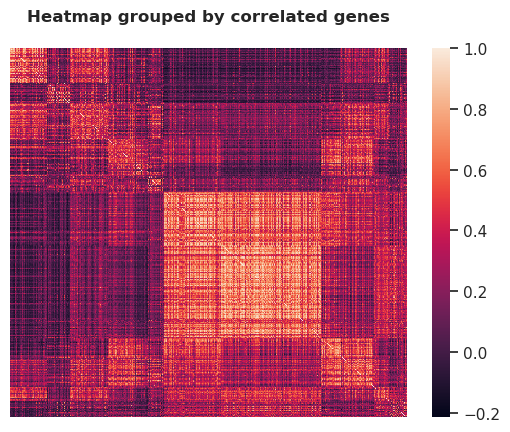

In [20]:
#Analysis of correlations

#Create standardized dataset without independent variable
x = df_std.drop(df_std.columns[-1], axis=1)

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly
    correlated variables are next to eachother

    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold,
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

sns.heatmap(cluster_corr(x.corr()), xticklabels=False, yticklabels=False).set_title("Heatmap grouped by correlated genes", fontweight='bold', y=1.05)


A **clustered heatmap** was generated to form a **correlation matrix** between the genes, so that **highly correlated genes** are grouped together in the matrix. The gene labels were omitted to facilitate interpretation of the results. It is possible to observe the occurrence of **many correlated genes**, either directly or inversely. Directly correlated genes are grouped near the hypotenuse of the triangle (diagonal of the square), while inversely correlated genes are grouped near the left side of the triangle. Near the bottom side of the triangle, genes with low correlation values among themselves are grouped. In summary, the high correlations presented demonstrate the possibility of an **effective dimensionality reduction of this dataset**.

### Dimensionality Reduction

#### Principal Component Analysis (PCA)

In [21]:
#PCA

#Inicializar o objeto PCA
pca = PCA(n_components=2)

pcomponents = pca.fit_transform(x)
pca_df = pd.DataFrame(data = pcomponents, columns = ["PC 1", "PC 2"], index = df_std.index)

#Adicionar variável independe a dataset com os componentes principais
final_pca_df = pd.concat([pca_df, df_std["Stress"]], axis=1)

In [22]:
final_pca_df

,PC 1,PC 2,Stress
info,,,
14-day-old seedling,-10.585646,-1.082805,Abio
"14-day-old seedling, heat shock",-9.579153,-0.428235,Abio
144hpi with array type rice from Affymetr,-20.258906,-4.932674,Bio
48hpia with array type rice from Affymetr,-20.274411,-4.953526,Bio
48hpib with array type rice from Affymetr,-20.278156,-4.959573,Bio
...,...,...,...
rice seedling grown under Pi-sufficient condition,13.705003,48.024431,Abio
temoin with array type rice from Affymetr,-20.253547,-4.934888,Bio
temoina with array type rice from Affymetr,-20.281120,-4.966821,Bio


Variation explained by the first 5 principal components: [0.33024175 0.13415908 0.08662043 0.04844749 0.04086625]
To explain 95% of the variance, it is necessary 39 components.


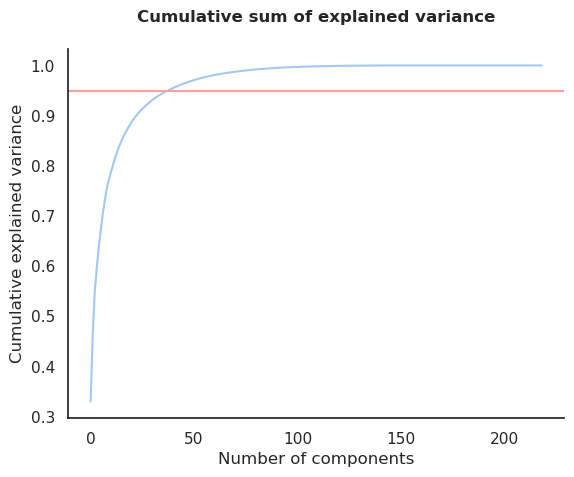

In [23]:
pca_d = PCA().fit(x)

pcomponents_d = pca_d.fit_transform(x)

#1º componente sumariza ~33%, 2ª componente sumariza ~13%, combinados ~47%
print('Variation explained by the first 5 principal components: {}'.format(pca_d.explained_variance_ratio_[:5]))

count = 0
total_comp = 0
for comp in pca_d.explained_variance_ratio_:
    if total_comp <=0.95:
        total_comp += comp
        count += 1
print(f"To explain 95% of the variance, it is necessary {count} components.")

pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum of explained variance', fontweight='bold',  y=1.05)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='-')

The dataset we are using suffers from the so-called "*Curse of Dimensionality*", which is common in omics expression data. This feature implies a **large number of variables** (genes) associated with a **small number of rows** (samples). This makes dimensionality reduction techniques particularly important for the interpretation and analysis of these data. The first technique of this kind we used was ***Principal Component Analysis*** (**PCA**). From the dataset with **1377 variables**, **2 principal components** were extracted that **cumulatively explain 47%** of the **total variation** of the dataset. Next, these 2 components were used to represent the samples in a two-dimensional space, to check if separation of the data into the two studied classes occurs.

Regarding the remaining components, we built a graph to visualize the **accumulation of variance** in the dataset by retaining an **increasing number** of variables. We conclude that of the **1377 initial variables**, we can reduce to **39 principal components** that summarize **95%** of the dataset variance. This matches the correlation analysis performed, confirming the hypothesis of **dimensionality reduction** for this dataset.

<Figure size 640x480 with 0 Axes>

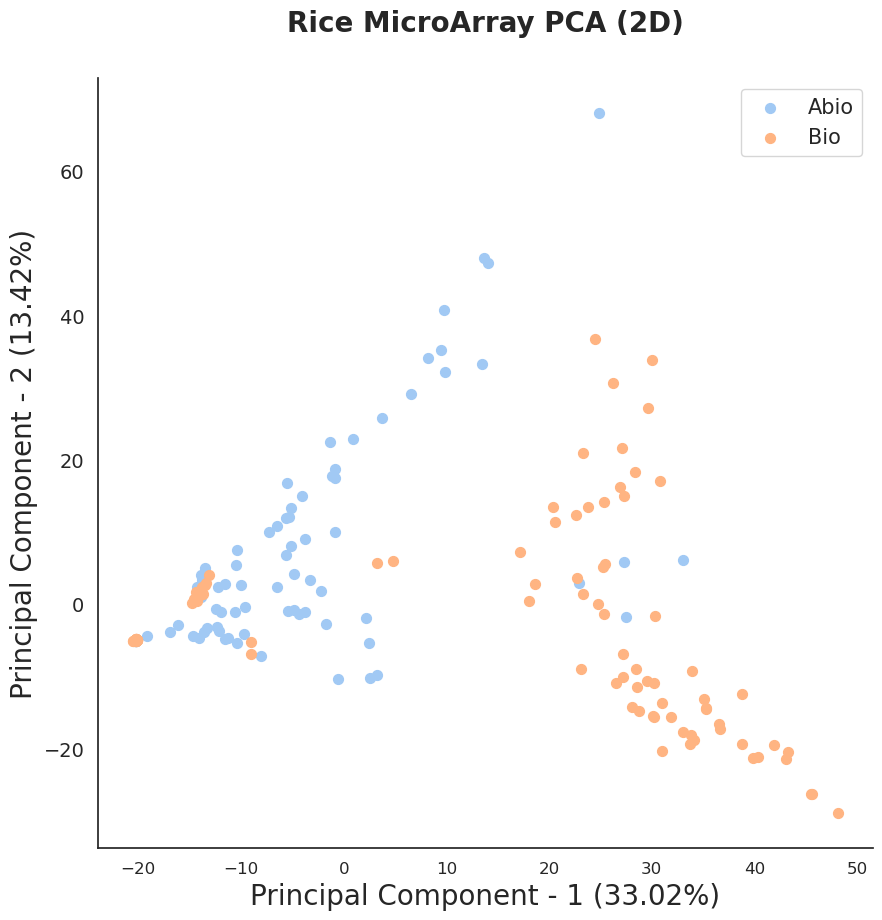

In [24]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(f'Principal Component - 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)',fontsize=20)
plt.ylabel(f'Principal Component - 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)',fontsize=20)
plt.title("Rice MicroArray PCA (2D)",y= 1.05, fontsize=20, fontweight='bold')
targets = ['Abio', 'Bio']
for target in targets:
    indicesToKeep = final_pca_df['Stress'] == target
    plt.scatter(final_pca_df.loc[indicesToKeep, 'PC 1']
               , final_pca_df.loc[indicesToKeep, 'PC 2'], s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

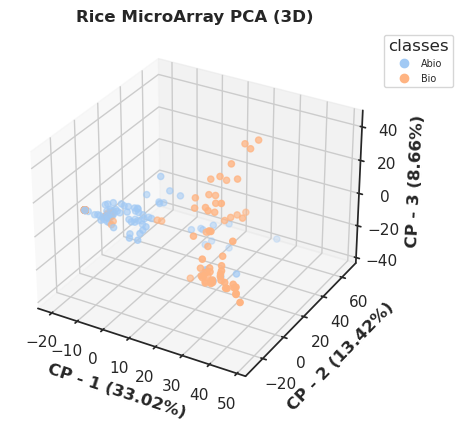

<Figure size 640x480 with 0 Axes>

In [25]:
#PCA 3D
pca = PCA(n_components=3)
x = df_std.drop(df_std.columns[-1], axis=1)
pcomponents = pca.fit_transform(x)
pca_df = pd.DataFrame(data = pcomponents, columns = ["PC 1", "PC 2", "PC 3"], index = df_std.index)

#Adicionar variável independe a dataset com os componentes principais
final_pca_df = pd.concat([pca_df, df_std["Stress"]], axis=1)

def pca_scatter_plot3d(x_pca, target, pca1=0, pca2=1, pca3=2, title=None, show=True):
        """
        Scatter plot of the labels based on three components (by default the first ones).
        Retrieves graphic showing the positions of labels according of the two chosen components
        :param title: string. title of the scatter plot
        :param target: labels of dataset
        :param pca1: first pca to be considered. default PCA1
        :param pca2: second pca to be considered. default PCA2
        :param pca3: third pca to be considered. default PCA3
        :param show: Whether to show the plot or no. True by default.
        :param path_save: Path to save the plot. pca_scatter_plot.png by default.
        :return: None
        """
        plt.clf()
        n_color = len(np.unique(target))
        # Get Unique ec
        color_labels = np.unique(target)
        # List of colors in the color palettes
        rgb_values = sns.color_palette("pastel", n_color)  # 'set2'
        # Map ec to the colors
        color_map = dict(zip(color_labels, rgb_values))
        # Finally use the mapped values
        from mpl_toolkits import mplot3d
        ax = plt.axes(projection="3d")
        ax.scatter3D(x_pca["PC 1"], x_pca["PC 2"], x_pca["PC 3"],
                     c=target.map(color_map))
        # create legend
        # classes  - colour labels
        # class_colours rgb values
        from matplotlib.lines import Line2D
        recs = []
        for i in range(0, n_color):
            recs.append(Line2D((0, 0.75), (0, 0), color=rgb_values[i], marker='o', linestyle=''))
            # recs.append(mpatches.Circle((0, 0), 0.5, fc=rgb_values[i]))
        n_col = int(n_color / 23) + 1
        lgd = plt.legend(recs, color_labels, bbox_to_anchor=(1, 1), loc="upper left",
                         fontsize='xx-small', ncol=n_col, shadow=False, title='classes')
        # add labels and title
        ax.set_xlabel(str(f'CP - 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)'), fontweight='bold')
        ax.set_ylabel(str(f'CP - 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)'), fontweight='bold')
        ax.set_zlabel(str(f'CP - 3 ({round(pca.explained_variance_ratio_[2]*100,2)}%)'), fontweight='bold')
        if title is None:
            title = "Rice MicroArray PCA (3D)"
        plt.title(title,  fontweight='bold' )
        if show is True:
            plt.show()
        plt.clf()
        

pca_scatter_plot3d(x_pca=final_pca_df, target=final_pca_df["Stress"])


After representing the samples in the factorial map, a **distinction** between the **types of stress** is observed along the **axis** of the **first component**, which explains the largest share of the observed variability. Along the **second component**, a **dispersion of samples** is observed, which is not as relevant for class separation. However, it is possible to observe that **a portion** of **biotic stresses** is **grouped together** with the vast majority of **abiotic stresses**, and the same occurs, to a lesser extent, with **abiotic stresses**. The addition of a **third component**, which explains ~9% of the dataset variance, allows a clearer **distinction of stresses** along the z-axis. Overall, a **good separation** between the studied classes is observed.

#### Partial Least Squares - Discriminant Analysis (PLS-DA)

In [26]:
#PLS-DA

#Initialize PLS-DA
pls_da = PLSRegression(n_components=2, scale=False)

#Build dummy variable for the "Stress" variable
df_one = pd.get_dummies(df_std["Stress"])
df_two = pd.concat((df_one, df_std), axis=1)
df_two = df_two.drop(["Stress"], axis=1)
df_two = df_two.drop(["Abio"], axis=1)
result = df_two.rename(columns={"Bio": "Stress"})

#Fit the model to the data
pls_da = pls_da.fit(x.values, result["Stress"].values)

#Build dataset with PLS-DA results
pls_scores = pls_da.x_scores_
pls_scores = pd.DataFrame(pls_scores, columns=["C 1", "C 2"], index=final_pca_df.index)

#calcular o peso dos componentes
total_variance_in_x = np.var(x.values, axis = 0)
variance_in_x = np.var(pls_da.x_scores_, axis = 0)
fractions_of_explained_variance = variance_in_x / sum(total_variance_in_x)
print('Explained variation per component: {}'.format(fractions_of_explained_variance))

Explained variation per component: [0.20879221 0.13081812]


Another dimensionality reduction technique used was **PLS-DA**, as recommended by the authors of the study on which this work is based. The **2 extracted components** **cumulatively explain** about **34% of the total variance** of the dataset, which is **lower** than observed in **PCA**.

<Figure size 640x480 with 0 Axes>

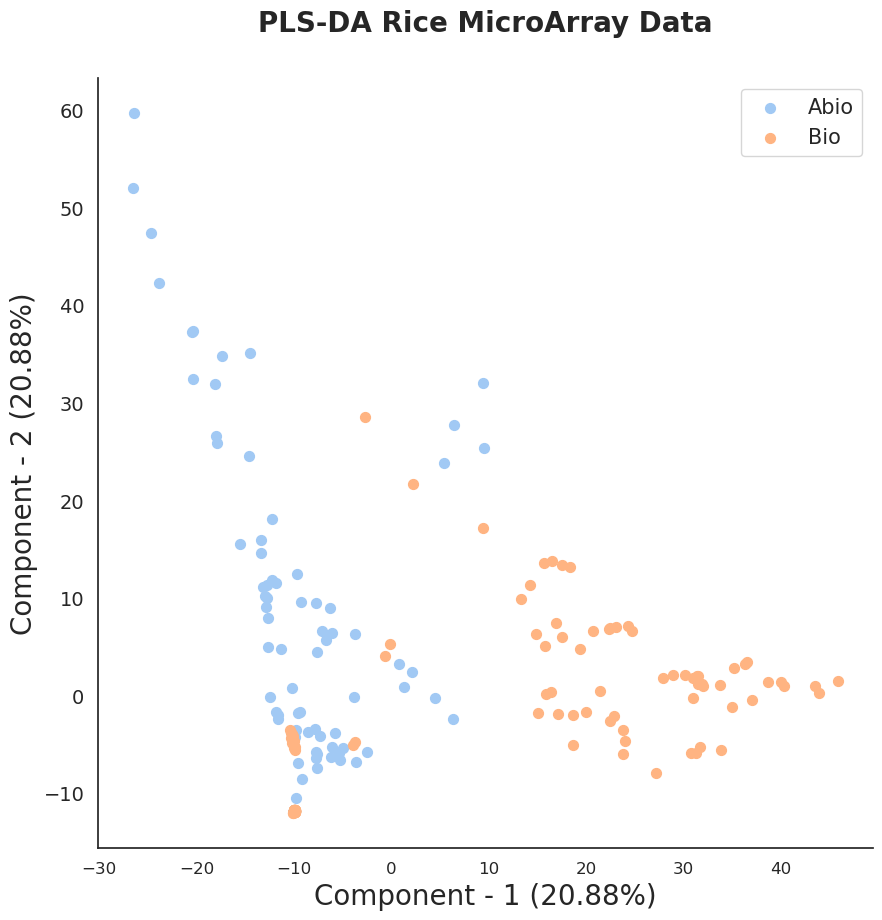

In [27]:
#View graph with component results

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(f'Component - 1 ({round(fractions_of_explained_variance[0]*100, 2)}%)',fontsize=20)
plt.ylabel(f'Component - 2 ({round(fractions_of_explained_variance[0]*100, 2)}%)',fontsize=20)
plt.title("PLS-DA Rice MicroArray Data",fontsize=20, y=1.05, fontweight='bold')
targets = ['Abio', 'Bio']

for target in targets:
    indicesToKeep = final_pca_df['Stress'] == target
    plt.scatter(pls_scores.loc[indicesToKeep, 'C 1']
               , pls_scores.loc[indicesToKeep, 'C 2'], s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()


Similar to **PCA**, a **separation** of the **classes** is observed along the **first component** and a particular **dispersion** of the **Abio class** along the **second component**. As observed above, there is some **mixing between** the **classes** with some **Bio stresses grouped** with those of the **Abio class** and vice versa. Overall, although it presents a lower total percentage of dataset variance in the factorial map, this technique **manages to separate** the two classes with **similar effectiveness** to **PCA**.

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

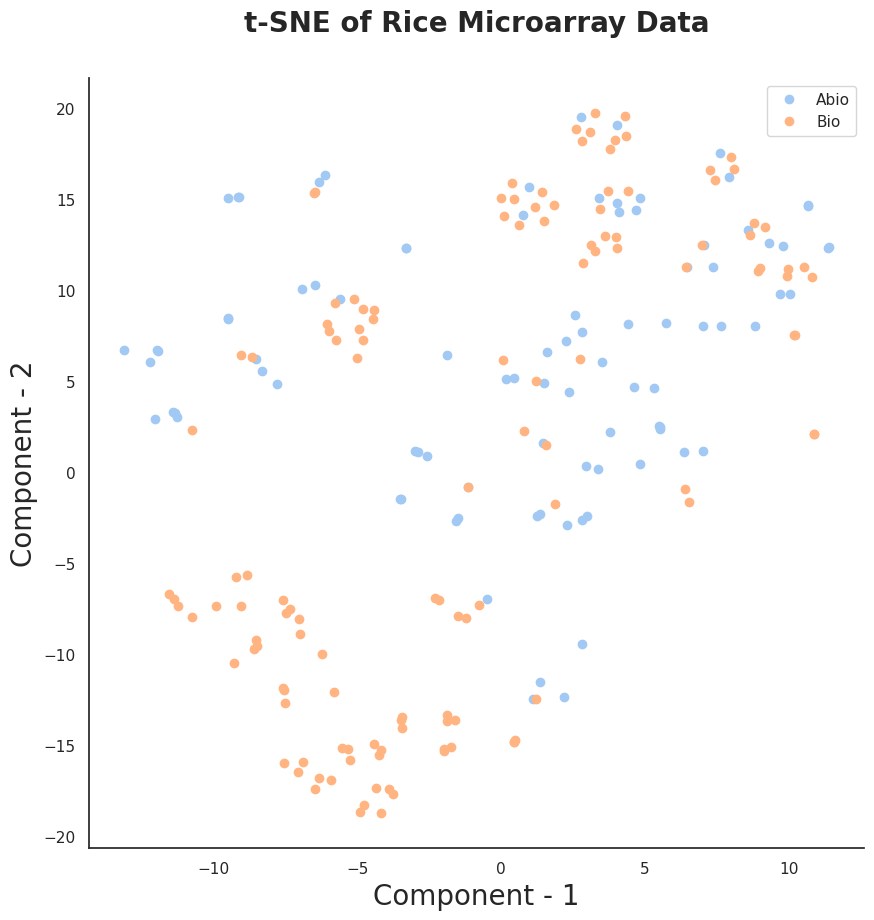

In [28]:
# t-SNE

# Initialize t-SNE
tsne = TSNE(n_components=2, n_iter=1000)

# Fit and transform the data
points = tsne.fit_transform(x.values)

# Prepare index for plotting
df_std_ni = df_std.reset_index(drop=True)

plt.figure(figsize=(10,10))

# Plot t-SNE results
for stress in df_std_ni['Stress'].unique():
    sp = df_std_ni.index[df_std_ni['Stress'] == stress] - 1
    plt.plot(points[sp, 0], points[sp, 1], 'o', label=stress)

plt.title("t-SNE of Rice Microarray Data", fontsize=20, y=1.05, fontweight='bold')
plt.xlabel('Component - 1', fontsize=20)
plt.ylabel('Component - 2', fontsize=20)
plt.legend(loc='best', shadow=False)
plt.show()

The last dimensionality reduction technique used was **t-SNE**, given its proven effectiveness for unsupervised classification of large datasets. After applying the technique, it is observed that there is a **good grouping** of **samples** classified as **biotic stresses** in the **second quadrant** of the plot, although there is a **weak separation between** the **classes** in the **other quadrants**. Overall, we believe this technique **did not perform as well** as the other two techniques presented above, **possibly due** to the **small number of samples** in the dataset.

### Clustering

#### K-Means

In [29]:
# K-MEANS

#Initialize K-Means
kmeans = KMeans(n_clusters = 2, random_state = 42, max_iter = 300, n_init = 10)
kmeans_f = kmeans.fit(x.values)

#Cross table com resultados dos clusters K-Means
labels = kmeans_f.labels_

print(pd.crosstab(labels, df_std["Stress"], rownames = ["clusters"]))


Stress    Abio  Bio
clusters           
0           13   60
1           78   68


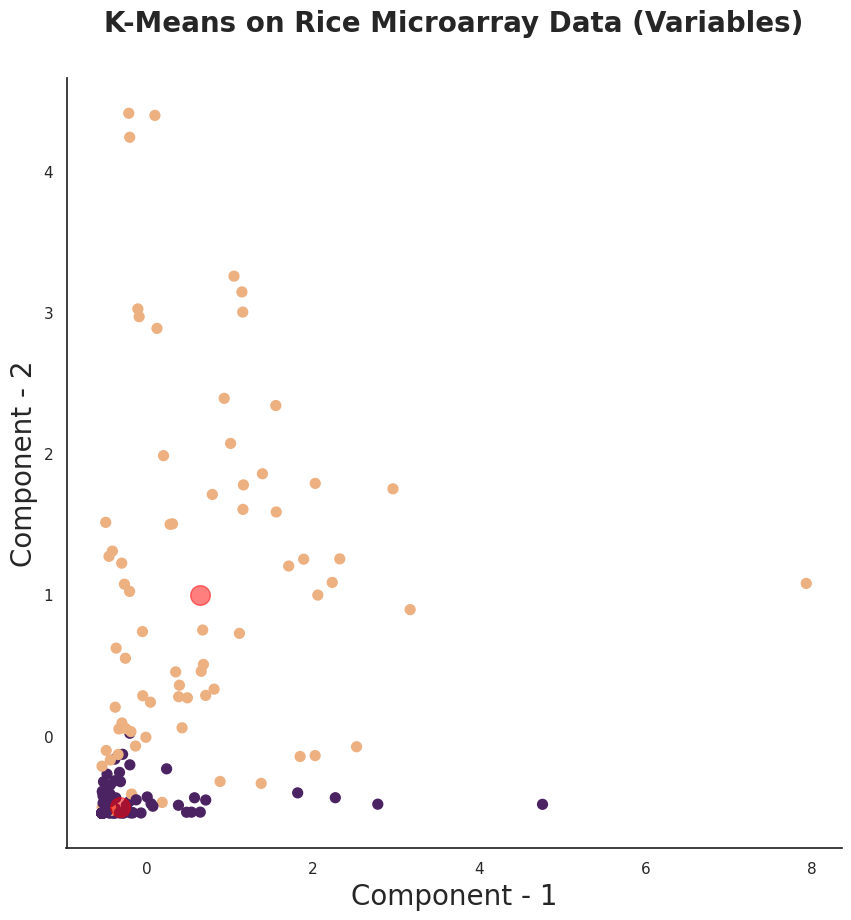

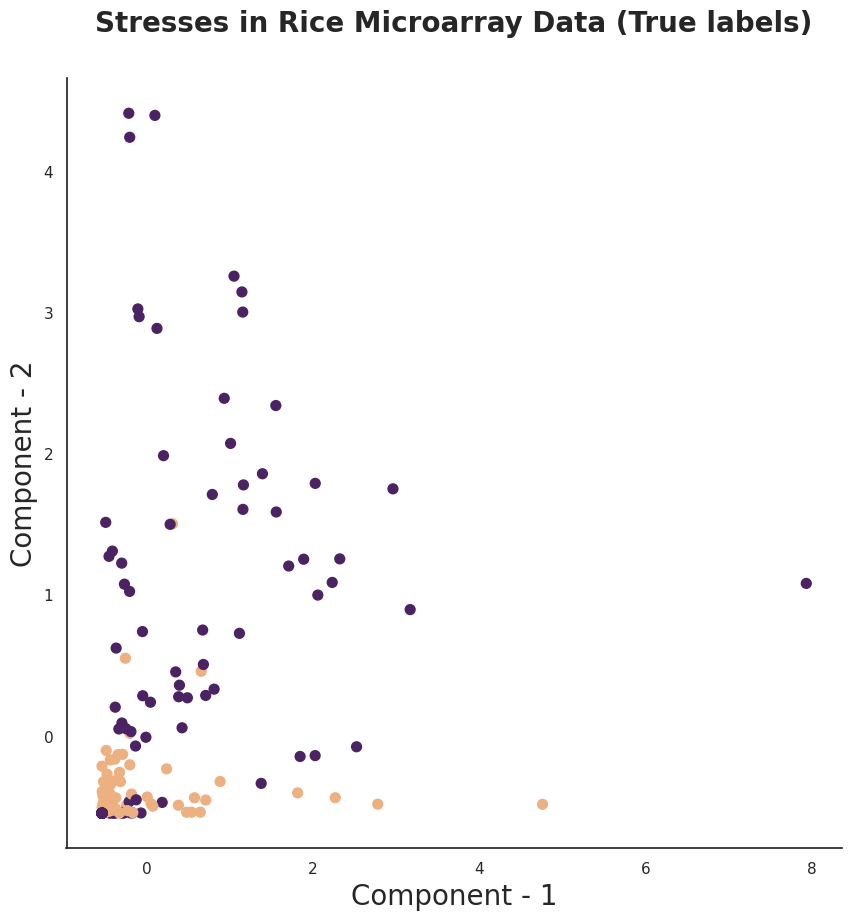

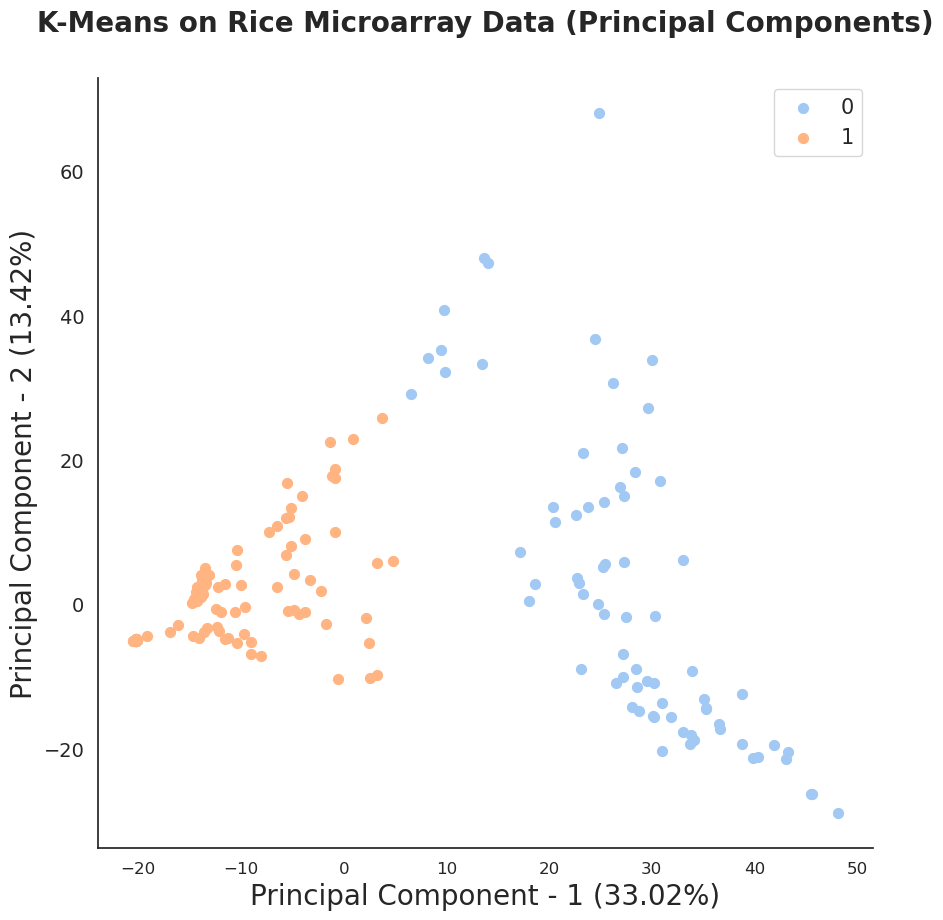

In [30]:
# Make predictions to obtain cluster assignments
y_pred_kmeans = kmeans_f.predict(x.values)

# Visualize K-Means group assignments and cluster centers (using first two variables)
plt.figure(figsize=(10,10))
plt.scatter(x.values[:, 0], x.values[:, 1], c=y_pred_kmeans, s=50, cmap="flare")
centers = kmeans_f.cluster_centers_
plt.title("K-Means on Rice Microarray Data (Variables)", fontsize=20, y=1.05, fontweight='bold')
plt.xlabel('Component - 1', fontsize=20)
plt.ylabel('Component - 2', fontsize=20)
plt.scatter(centers[:, 0], centers[:, 1], c="red", s=200, alpha=0.5)
plt.show()

# Visualize true group assignments
plt.figure(figsize=(10,10))
plt.scatter(x.values[:, 0], x.values[:, 1], c=result["Stress"].values, s=50, cmap="flare")
plt.title("Stresses in Rice Microarray Data (True labels)", fontsize=20, y=1.05, fontweight='bold')
plt.xlabel('Component - 1', fontsize=20)
plt.ylabel('Component - 2', fontsize=20)
plt.show()

# K-Means PCA visualization (plot clusters on the first two principal components)
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(f'Principal Component - 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)', fontsize=20)
plt.ylabel(f'Principal Component - 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)', fontsize=20)
plt.title("K-Means on Rice Microarray Data (Principal Components)", y=1.05, fontsize=20, fontweight='bold')
targets = [0, 1]
for target in targets:
    indicesToKeep = y_pred_kmeans == target
    plt.scatter(final_pca_df.loc[indicesToKeep, 'PC 1'],
                final_pca_df.loc[indicesToKeep, 'PC 2'], s=50)

plt.legend(targets, prop={'size': 15})
plt.show()


Following the previous analyses, we applied **unsupervised classification techniques** to **separate** the **samples** into the corresponding classes of **biotic** and **abiotic stress**. The first technique we used was **K-Means**. The algorithm was tasked with creating 2 clusters, as an attempt to see how well it could separate the samples. Of the **128** samples corresponding to **biotic stress** and the **91** corresponding to **abiotic stress**, the algorithm generated **2 clusters**, with one (**cluster 0**) classifying **mostly** biotic stress and some samples as abiotic stress, and in the other (**cluster 1**) there is a percentage close to **50%** between biotic and abiotic stress, with a **slight enrichment** in the classification of abiotic stress. Overall, a **moderate classification success** of the samples by the **K-Means** algorithm is observed, particularly affecting those corresponding to **abiotic stress**.

Of the graphs presented, the **first** represents the **samples** colored by the **classification** of the **K-Means** algorithm, the **second** shows the **samples** colored **according to their classification** between biotic and abiotic stress, and the **third** shows the samples colored by the **classification** of the **K-Means** algorithm, but projected onto the first **two principal components** obtained from the PCA.

#### Hierarchical Clustering

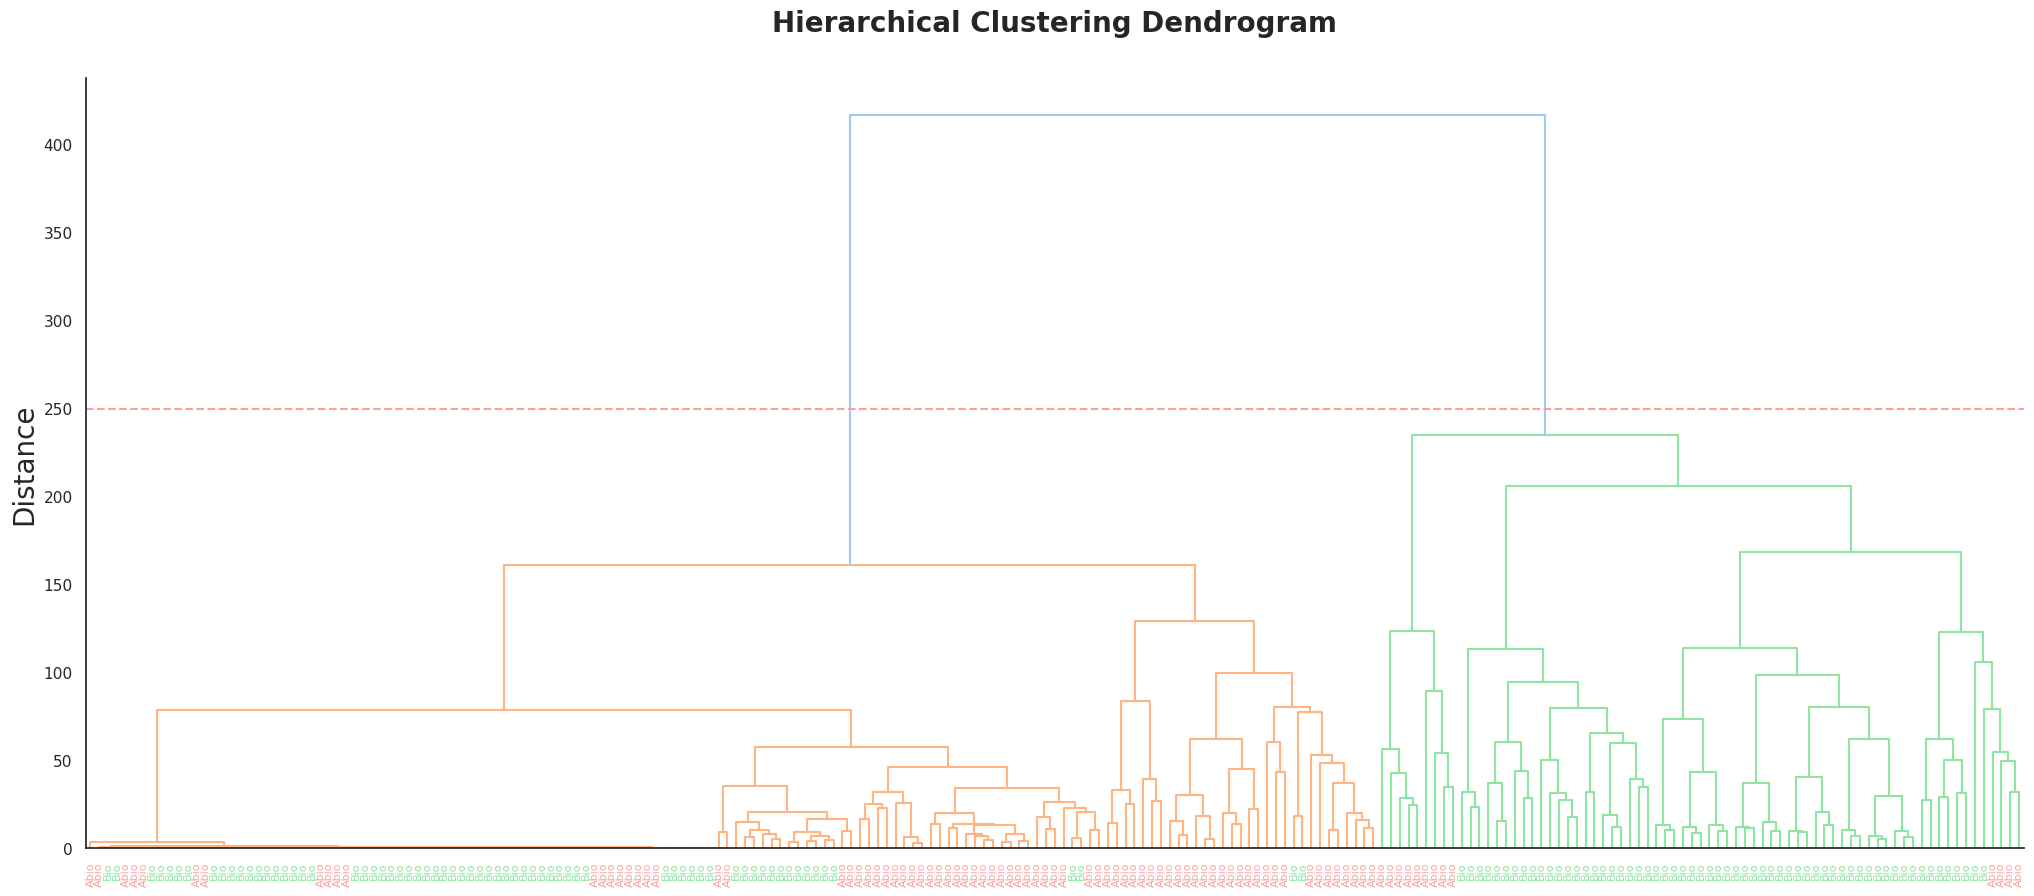

In [31]:
# Hierarchical clustering
# Build and display the dendrogram

# Run algorithm using Ward's method and Euclidean distances
Z = linkage(x.values, method='ward', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_std.iloc[:, -1]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram', fontsize=20, y=1.05, fontweight='bold')
plt.ylabel('Distance', fontsize=20)

# Color the labels according to stress type: 'Abio' -> red, 'Bio' -> green
label_colors = {'Abio': 'r', 'Bio': 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors.get(lbl.get_text(), 'k'))
plt.axhline(y=250, color='r', linestyle='--')
plt.show()


The last **unsupervised analysis** technique applied to the dataset was **hierarchical clustering**, of the **agglomerative** type.
The metric used was **euclidean distance**, and the method used was the **Ward method**.

Observation of the **dendrogram** built from the dataset reveals the existence of **2 large clusters** that **separate at the beginning of the tree**, and this information can be interpreted on a multidimensional scale. Looking at the **leaves**, we can conclude that the **cluster** on the **right**, in green, mostly groups samples from **biotic stresses**, while the samples in the **left cluster**, in orange, aggregate a **mix** of **biotic** and **abiotic stress**. However, it presents **sub-clusters** where **abiotic stresses** are **grouped together**.

In [32]:
# Hierarchical clustering for classifying the samples

# Initialize the model
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

#Predict the clusters
cluster.fit_predict(x.values)

print(pd.crosstab(cluster.labels_, df_std["Stress"], rownames = ["clusters"]))


Stress    Abio  Bio
clusters           
0           13   60
1           78   68


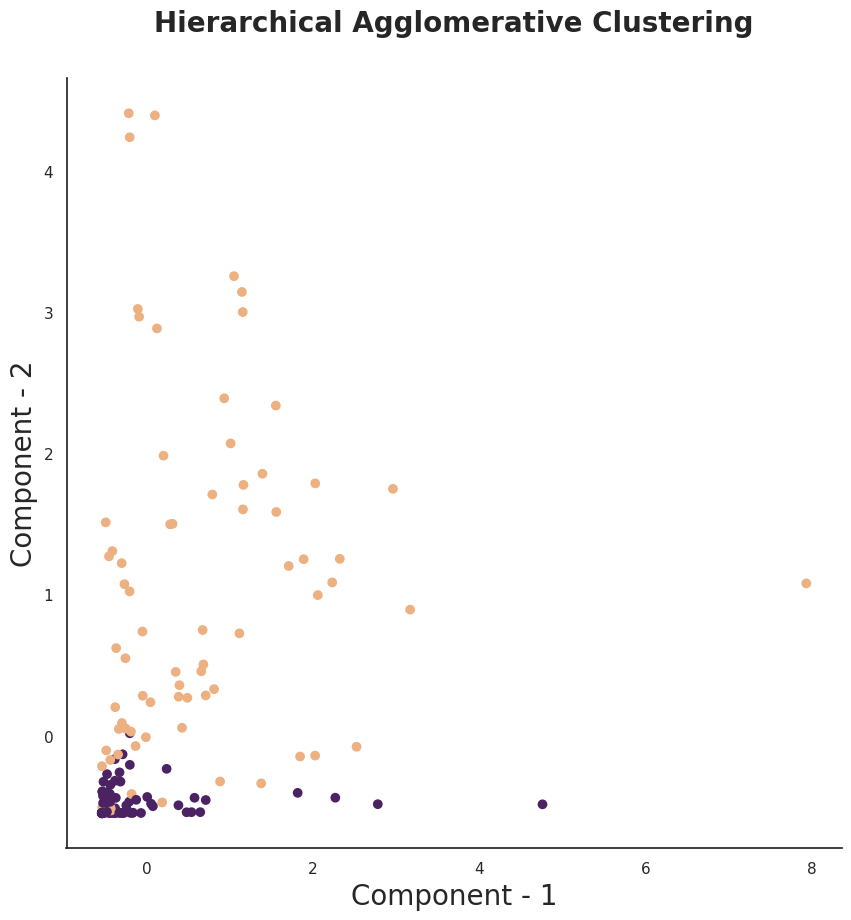

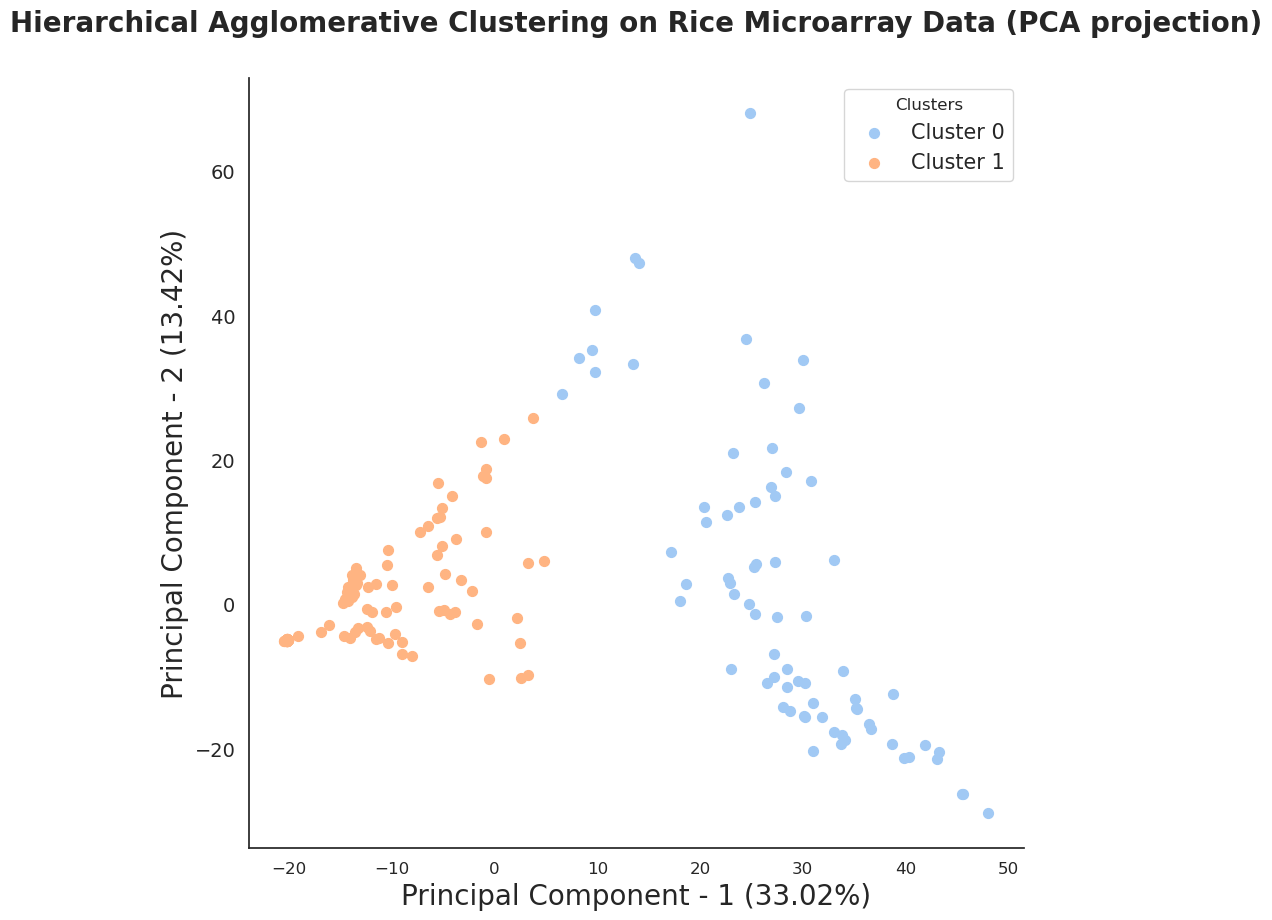

In [33]:
# Visualize clustering (labels and projection on first two principal components)

plt.figure(figsize=(10,10))
plt.scatter(x.values[:,0], x.values[:,1], c=cluster.labels_, cmap="flare")
plt.title('Hierarchical Agglomerative Clustering', fontsize=20, y=1.05, fontweight='bold')
plt.xlabel('Component - 1', fontsize=20)
plt.ylabel('Component - 2', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(f'Principal Component - 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)', fontsize=20)
plt.ylabel(f'Principal Component - 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)', fontsize=20)
plt.title("Hierarchical Agglomerative Clustering on Rice Microarray Data (PCA projection)", y=1.05, fontsize=20, fontweight='bold')

targets = [0, 1]
for target in targets:
    indicesToKeep = cluster.labels_ == target
    plt.scatter(final_pca_df.loc[indicesToKeep, 'PC 1'],
                final_pca_df.loc[indicesToKeep, 'PC 2'], s=50, label=f'Cluster {target}')

plt.legend(prop={'size': 15}, title='Clusters')
plt.show()


After analyzing the dendrogram, a **hierarchical clustering** for **2 clusters** was applied to the dataset and used to obtain the **assignments** of **each sample** to **each cluster**. This information is graphically represented in the factorial map above, showing a distribution similar to that observed in the **K-Means** analysis. This is even more evident when the samples are projected onto the first **two principal components** from the PCA, showing the **same classification** as the K-Means algorithm.

## Summary

From the analysis of the results obtained so far, we can **provisionally conclude** that despite the occurrence of **variables that do not help distinguish** between **biotic** and **abiotic stress**, the **unsupervised analyses** show a **separation** between these **two classes**, **particularly** for samples from **biotic stress**. We now hope that using supervised analyses, we can train a model capable of **correctly classifying** the sample as coming from **biotic** or **abiotic stress**, based on **gene expression microarray data** for the set of genes in the dataset.

### Phase 3

# Supervised Analysis

After performing the **univariate** and **unsupervised** analysis with the dataset at our disposal, we set out to create a **Machine Learning** model that, from a given set of **gene expression data** (microarrays), could correctly predict whether the plant had been exposed to **biotic** or **abiotic stresses**. Thus, we present below our pipeline for **supervised analysis**.

## Dataset Import

To start the ***Machine Learning*** (**ML**) part, we first loaded a csv (**Final_ds.csv**) containing the dataset used in the previous phase. However, in this phase it was necessary to **binarize** the **Stress variable**, in order to calculate the metrics for each of the ML models we built. Thus, we assigned the value **1** to the **Bio** category and **0** to the **Abio** category.

In [34]:
#Re_Importing Dataset
df = pd.read_csv("Final_ds.csv")

#Making variable binary
df["Stress"] = df["Stress"].replace({"Bio": 1, "Abio": 0})

#Setting X (features) and y (labels)
X = df.iloc[:, 1:-1].values
y = df["Stress"].values

## Analysis Preparation

In the first phase, we will train and evaluate **ML** models without performing ***Feature Selection***. Note that our data **do not allow** regression models, which is why we only **use classification models**. Since we only have two classes to which our data can be assigned, our **classifications** are **binary**.
To facilitate the process of training **ML** models, we created the function below, which gives an initial idea of how the model will perform, through ***Cross Validation*** (**CV**), as well as its real performance during training and prediction.
Model evaluation will be based on the metrics **accuracy**, **recall**, **precision**, **F1 score** and **ROC AUC**.

- **balanced_acuracy**: calculates the accuracy of a subset, i.e., it is defined as the average recall obtained in each class. The best value is 1 and the worst is 0 when adjusted = False.

- **recall**: corresponds to the ratio tp / (tp + fp), where tp is the number of true positives and fp is the number of false positives. Recall measures the classifier's ability to find all positive samples.

- **precision**: corresponds to the ratio tp / (tp + fp), where tp is the number of true positives and fp is the number of false positives. Precision measures the classifier's ability not to label a positive sample as negative. It ranges from 0 (worst score) to 1 (best score).

- **f1_weighted**: average of precision and recall, ranging from 0 (worst score) to 1 (best score). It is calculated as: F1 = 2 * (precision * recall) / (precision + recall)

- **roc_auto**: calculates the area under the receiver operating characteristic curve using predictive scores.

In [35]:
def run_ml_algorithms(models, x_train, y_train, x_test, y_test, cv,indexes, filename):

    ## cv evaluation before training
    # metrics
    cv_acc = []
    cv_recall = []
    cv_prec = []
    cv_f1 = []
    cv_roc_auc = []

    for model in models:
        # print(f"cv {model}")
        cv_acc.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='balanced_accuracy', n_jobs=-1)))
        cv_recall.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='recall', n_jobs=-1)))
        cv_prec.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='precision', n_jobs=-1)))
        cv_f1.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)))
        cv_roc_auc.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='roc_auc', n_jobs=-1)))

    ##ML train
    ml_acc = []
    ml_recall = []
    ml_prec = []
    ml_f1 = []
    ml_roc_auc = []

    for model in models:
        # print(f"ML {model}")
        y_pred = model.fit(x_train, y_train).predict(x_test)
        ml_acc.append(accuracy_score(y_test, y_pred))
        ml_recall.append(recall_score(y_test, y_pred, average='binary', pos_label=1))  # ability to find all positive samples
        ml_prec.append(precision_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0))
        ml_f1.append(f1_score(y_test, y_pred, average='binary', pos_label=1))  # relevant label F1-score
        ml_roc_auc.append(roc_auc_score(y_test, y_pred))

    total_dict = {"Accuracy CV": [acc for acc in cv_acc], "Recall CV": [rc for rc in cv_recall],"Precision CV": [prec for prec in cv_prec],
                  "F1 score CV": [f1 for f1 in cv_f1], "ROC AUC CV": [roc for roc in cv_roc_auc], "Accuracy ML": [acc for acc in ml_acc], "Recall ML": [rc for rc in ml_recall],
                  "Precision ML": [prec for prec in ml_prec], "F1 score ML": [f1 for f1 in ml_f1], "ROC AUC ML": [roc for roc in ml_roc_auc]}

    df_total = pd.DataFrame.from_dict(total_dict)
    df_total = df_total.set_index(model for model in indexes)
    df_total.to_csv(filename)

    return df_total

To perform **ML**, the standardized dataset was divided into the set of **features**, which are the variables used to train the model, and the variable we want to classify (**label**). These two datasets were then split into a **training set** and a **test set**, with 70% and 30% of the original data, respectively.

To help us determine the best **ML** model, we used **cross-validation**, specifically Repeated **k-fold Cross-Validation**, using 3 repetitions and 10 folds per repetition.

**Reproducibility** of results was ensured by setting a **random seed**, which was used in the random state parameters of the other functions used.

In [36]:
#Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Validação cruzada
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#Setting up random State
rand_seed = 1735038

To perform **ML** using our dataset, we face a **binary classification** problem. Thus, we selected and tested **ML** models capable of performing this analysis. A total of **9 models** were tested, corresponding to ***Logistic Regression***, ***Naive-Bayes***, **k-Nearest Neighbor (KNN)**, ***Decision Tree***, ***Random Forest***, ***Support Vector Classification***, **Neural Network Multi-layer Perceptron (MLP)**, ***Bagging Classifier using Random Forest*** and ***AdaBoost***.

In the logistic regression and MLP models, a maximum of **1000 iterations** was set. In the KNN model, it was parameterized to use **2 neighbors**. Finally, the Decision Tree, Random Forest and Bagging Classifier models take the ***random seed*** defined above to ensure reproducibility.

In [37]:
#ML models
lgr = LogisticRegression(max_iter=1000, n_jobs=-1)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
dt = DecisionTreeClassifier(random_state=rand_seed)
rf = RandomForestClassifier(n_jobs=-1, random_state=rand_seed)
svc = SVC()
mlp = MLPClassifier(max_iter=1000)
bc_rf = BaggingClassifier(RandomForestClassifier(n_jobs=-1, random_state=rand_seed))
ada = AdaBoostClassifier()

models = [lgr, gnb, knn, dt, rf, svc, mlp, bc_rf, ada]
models_index = ["Logistic Regression", "Naive-Bayes", "KNN", "Decision Tree", "Random Forest", "SVM", "Neural Networks", "Bagging Classifier RF", "Ada Boost Classifier"]

## Machine Learning

### Without Feature Selection

After defining the models, we used the ***run_ml_algorithms*** function to run and evaluate them, comparing the results of cross-validation with a single instance of ML. Both for ***cross-validation*** and **ML**, the output of the ***train_test_split*** function was used.

The final section of the ***run_ml_algorithms*** function aggregates the metrics into a single dataset, which serves as support for their ***comparison***. In this initial approach, we used the complete datasets for training.

In [38]:
Metrics_no_FS = run_ml_algorithms(models=models, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cv=cv, indexes=models_index, filename = "Metric_no_FS.csv")

Metrics_no_FS

,Accuracy CV,Recall CV,Precision CV,F1 score CV,ROC AUC CV,Accuracy ML,Recall ML,Precision ML,F1 score ML,ROC AUC ML
Logistic Regression,0.883246,0.963832,0.868883,0.890339,0.968980,0.893939,1.000000,0.857143,0.923077,0.854167
Naive-Bayes,0.670662,0.467581,0.842103,0.626764,0.760966,0.681818,0.500000,1.000000,0.666667,0.750000
KNN,0.943807,0.923858,0.972538,0.939820,0.952071,0.939394,0.952381,0.952381,0.952381,0.934524
Decision Tree,0.808137,0.822664,0.840625,0.807314,0.808137,0.909091,0.952381,0.909091,0.930233,0.892857
Random Forest,0.924548,0.933555,0.937168,0.923711,0.988606,0.969697,1.000000,0.954545,0.976744,0.958333
SVM,0.814642,0.951347,0.802073,0.819412,0.849020,0.878788,1.000000,0.840000,0.913043,0.833333
Neural Networks,0.882327,0.971254,0.872830,0.892183,0.953267,0.893939,1.000000,0.857143,0.923077,0.854167
Bagging Classifier RF,0.918166,0.933555,0.923397,0.915036,0.981136,0.924242,0.976190,0.911111,0.942529,0.904762
Ada Boost Classifier,0.935085,0.960051,0.940316,0.938710,0.985937,0.954545,0.976190,0.953488,0.964706,0.946429


<AxesSubplot:title={'center':'$\\it{Machine}$ ${Learning}$'}>

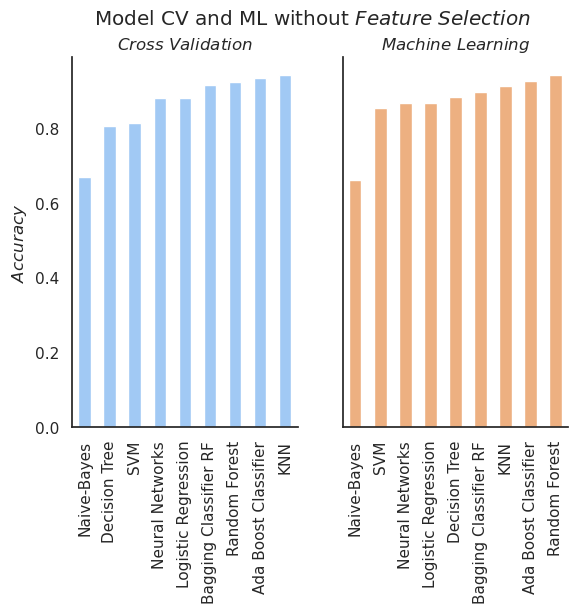

In [39]:
"""
Plot for accuracy of CV and ML without feature selection
"""


fig, axes = plt.subplots(1, 2)
fig.suptitle('Model CV and ML without $\it{Feature}$ $\it{Selection}$')

axes[0].set_title('$\it{Cross}$ ${Validation}$')
axes[1].set_title('$\it{Machine}$ ${Learning}$')

for ax in axes.flat:
    ax.set(ylabel='$\it{Accuracy}$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()

Metrics_no_FS.sort_values('Accuracy CV', inplace=True)

Metrics_no_FS.plot(y='Accuracy CV', kind='bar', legend=False, ax=axes[0])

Metrics_no_FS.sort_values('Accuracy ML', inplace=True)

Metrics_no_FS.plot(y='Accuracy ML', kind='bar', legend=False, ax=axes[1], cmap='flare')

Analyzing the ***accuracy*** of the evaluated models, we see that in both scenarios presented the ***Naive-Bayes*** model has the **lowest accuracy**, around 70%. As for the best models, we see that, in terms of ***accuracy***, the top three models in the **cross-validation** scenario are ***Random Forest*** (92.45%), ***AdaBoost*** (93.51%) and ***KNN*** (94.38%). In the ***Machine Learning*** scenario, the top three models are ***KNN*** (93.9%), ***AdaBoost*** (95.4%) and ***Random Forest*** (96.97%). Comparing the two scenarios, in terms of ***accuracy***, the best model in the ***CV*** scenario, ***KNN***, has slightly lower accuracy than the best model in the ***ML*** scenario, ***Random Forest***. This may be due to the ***Random Seed*** defined, which may bias the model toward optimality in the first iteration.

### Feature Selection

In a second instance, we decided to proceed with ***Feature Selection*** to see if selecting features would bring any improvement to our models or if with a smaller number of features we could achieve results similar to those obtained with the complete dataset. For ***Feature Selection***, we selected the ***SelectKBest*** method with the **score function** ***f_classif***, and chose to select 600 features from the dataset.

In [40]:
#feature selction
X_features = SelectKBest(score_func=f_classif, k=600).fit_transform(X,y)

#Train_Test_Split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_features, y, test_size=0.3, random_state=0)

In [41]:
Metrics_FS = run_ml_algorithms(models=models, x_train=X_train_f, y_train=y_train_f, x_test=X_test_f, y_test=y_test_f, cv=cv, indexes=models_index, filename = "Metric_FS.csv")

Metrics_FS

,Accuracy CV,Recall CV,Precision CV,F1 score CV,ROC AUC CV,Accuracy ML,Recall ML,Precision ML,F1 score ML,ROC AUC ML
Logistic Regression,0.872736,0.968131,0.854362,0.880861,0.945976,0.893939,1.000000,0.857143,0.923077,0.854167
Naive-Bayes,0.685311,0.475451,0.863413,0.639870,0.778798,0.681818,0.500000,1.000000,0.666667,0.750000
KNN,0.952557,0.933487,0.983241,0.950563,0.959175,0.909091,0.928571,0.928571,0.928571,0.901786
Decision Tree,0.828462,0.853604,0.850470,0.827043,0.828462,0.924242,0.976190,0.911111,0.942529,0.904762
Random Forest,0.929773,0.937721,0.946122,0.930385,0.986282,0.954545,1.000000,0.933333,0.965517,0.937500
SVM,0.817115,0.944983,0.803689,0.821755,0.861512,0.878788,1.000000,0.840000,0.913043,0.833333
Neural Networks,0.884701,0.972298,0.866683,0.892137,0.949621,0.893939,1.000000,0.857143,0.923077,0.854167
Bagging Classifier RF,0.913371,0.933555,0.913873,0.910754,0.974860,0.924242,0.976190,0.911111,0.942529,0.904762
Ada Boost Classifier,0.924316,0.941358,0.939943,0.930568,0.979631,0.939394,0.952381,0.952381,0.952381,0.934524


<AxesSubplot:title={'center':'$\\it{Machine Learning}$'}>

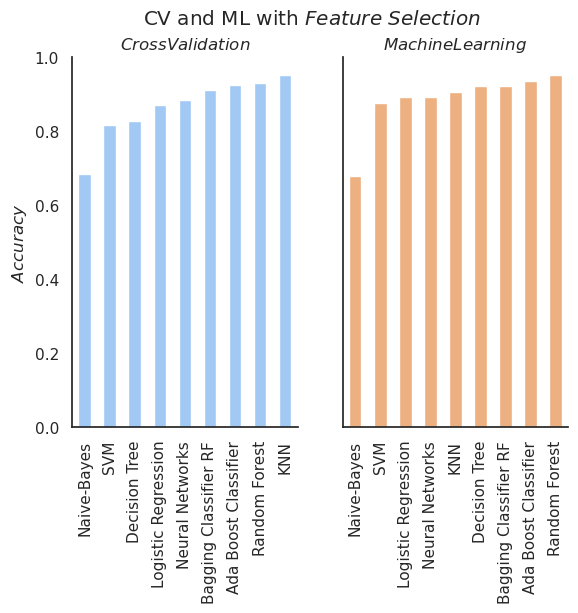

In [42]:
"""
Plot for accuracy of CV and ML with Feature Selection
"""


fig, axes = plt.subplots(1, 2)
fig.suptitle('CV and ML with $\it{Feature}$ $\it{Selection}$')

axes[0].set_title('$\it{Cross Validation}$')
axes[1].set_title('$\it{Machine Learning}$')

for ax in axes.flat:
    ax.set(ylabel='$\it{Accuracy}$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()

Metrics_FS.sort_values('Accuracy CV', inplace=True)

Metrics_FS.plot(y='Accuracy CV', kind='bar', legend=False, ax=axes[0])

Metrics_FS.sort_values('Accuracy ML', inplace=True)

Metrics_FS.plot(y='Accuracy ML', kind='bar', legend=False, ax=axes[1], cmap='flare')

Now evaluating the accuracy results in both scenarios after ***Feature Selection***, we see that the results are similar to those obtained using all features. In both scenarios, the model with the worst accuracy remains ***Naive-Bayes***, with values of 68.53% in the ***CV*** scenario and 68.18% in the ***ML*** scenario.

Comparing the ***accuracies of the top 3 models in both scenarios, we find some differences. In the ***CV*** scenario, the top three models are ***AdaBoost*** (92.64%), ***Random Forest*** (92.98%) and ***KNN*** (96.97%). In the ***ML*** scenario, these are ***Bagging Classifier*** (93.94%), ***AdaBoost*** (93.94%) and ***Random Forest*** (95.45%).

The biggest changes occur in the ***ML*** scenario, ***KNN*** is replaced by ***Bagging Classifier***, and the best accuracy in the ***CV*** scenario is now higher than the best in the ***ML*** scenario. Both values are lower than the best accuracies without ***Feature Selection***.

Overall, the biggest changes compared to the previous analysis occur in the ***ML*** scenario. First, the position of the ***KNN*** model in the top 3 is taken by the ***Bagging Classifier***. Next, the best ***accuracy*** in the ***CV*** scenario is now higher than the best in the ***ML*** scenario. Finally, we see that the best ***accuracy*** values in each scenario with ***feature selection*** are lower than their respective values without ***feature selection***.

## Hyperparameter Optimization

From the previous analyses, we found that the ***KNN*** and ***Random Forest*** models achieved the best ***accuracy*** values in the ***CV*** and ***ML*** scenarios, respectively. Therefore, these two models were selected for **hyperparameter optimization** to verify which of the two models actually has **better metrics** for classifying biotic and abiotic stress.

Due to the best ***accuracy*** values obtained in the absence of ***Feature Selection***, this was the ***default*** training mode from now on. For the optimization itself, a ***Grid Search*** optimization was chosen, with a set of parameters to be tested for each model.

In [43]:
#Hyperparameter Optimization

#Evaluation Function
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = 100 * accuracy_score(y_test,y_pred)
    print('Model Performance')
    print('Accuracy = {:0.2f}%. \n'.format(accuracy))
    return accuracy

### Random Forest

To optimize the hyperparameters in the ***Random Forest*** model, we first checked the list of **all the parameters** used by **default** in the algorithm.

In [44]:
# Create a base model
rf = RandomForestClassifier(n_jobs=-1, random_state=rand_seed)

#Get Parameters
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

rf = rf.fit(X_train, y_train)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1735038,
 'verbose': 0,
 'warm_start': False}


After consulting the **literature**, **6 parameters** were selected for optimization, corresponding to ***Bootstrap***, ***max_depth***, ***max_features***, ***min_samples_leaf***, ***min_samples_split*** and ***n_estimators***. These parameters have the greatest impact on the model's classification ability, and the ***GridSearch*** methodology will exhaustively test all possible combinations and return the best parameters.

In [45]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, None],
    'max_features': [2, 3, "auto"],
    'min_samples_leaf': [1, 3, 4],
    'min_samples_split': [1, 2, 4, 8, 10],
    'n_estimators': [80, 100, 200, 300, 1000]}

***Grid Search*** was performed using **3 cross-validations**.

In [46]:
tic = time()

# Instantiate the grid search model
grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=rand_seed), param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)

gs_time = time() - tic
print(f"The grid search lasted {gs_time} seconds \n")

print(f"Best parameters after hyperparameter optimization: \n {grid_search.best_params_}")

The grid search lasted 109.66768431663513 seconds 

Best parameters after hyperparameter optimization: 
 {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


After ***Grid Search***, we obtained the **best combination** of hyperparameters among those tested after their **optimization**.

In [47]:
print("Base Model")
base_accuracy = evaluate(rf, X_test, y_test)

print("Grid Search Model")
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Accuracy = 96.97%. 

Grid Search Model
Model Performance
Accuracy = 96.97%. 

Improvement of 0.00%.


Next, the model obtained from **hyperparameter optimization** was tested, evaluating its ***accuracy*** compared to the accuracy of a ***Random Forest*** model with **default parameters**.

It is found that there is **no improvement in model performance** after hyperparameter optimization, remaining at 96.97%. Thus, we can conclude that, based on the set of hyperparameters tested, the model has already **reached** the ***maximum accuracy*** possible with the parameters sought using the ***default*** settings.

### KNN

To optimize the **hyperparameters** in the ***KNN*** model, we first checked the list of all default parameters used by the algorithm.

In [48]:
# Create a base model
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)

# Look at parameters used by our current KNN
print('Parameters currently in use:\n')
pprint(knn.get_params())

knn = knn.fit(X_train, y_train)

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}


After consulting the **literature**, **6 parameters** were selected for optimization: ***algorithm***, ***n_neighbors***, ***leaf_size***, ***weights***, ***metric*** and ***p***. These parameters have the greatest impact on the model's **classification** ability, and the ***GridSearch*** methodology will exhaustively test all possible combinations and return the best parameters.

In [49]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]

grid_params = {"algorithm" : algorithm,'n_neighbors': n_neighbors, "leaf_size": leaf_size,
               'weights': ['uniform','distance'],
               'metric': ['minkowski','euclidean','manhattan'],
                "p": p}

In [50]:
t=time()

# Instantiate the grid search model
gs = GridSearchCV(KNeighborsClassifier(n_jobs=-1), grid_params, verbose=0, cv=3, n_jobs=-1)

gs_res = gs.fit(X_train, y_train)

gs_t = time() - t
print(f"The Grid Search lasted {gs_t} seconds \n")

print(f"Best parameters after hyperparameter optimization: \n {gs_res.best_params_}")

The Grid Search lasted 1167.5415678024292 seconds 

Best parameters after hyperparameter optimization: 
 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


After ***Grid Search***, we obtained the best combination of **hyperparameters** among those tested after their **optimization**.

In [51]:
print("Base Model")
base_accuracy = evaluate(knn, X_test, y_test)

print("Grid Search Model")
best_gs = gs_res.best_estimator_
random_accuracy = evaluate(best_gs, X_test, y_test)

print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Accuracy = 93.94%. 

Grid Search Model
Model Performance
Accuracy = 96.97%. 

Improvement of 3.23%.


Next, the model obtained from **hyperparameter optimization** was tested, evaluating its ***accuracy*** compared to the ***accuracy*** of a ***KNN*** model with ***default*** parameters.

After **hyperparameter optimization**, a **3.23% improvement** in ***accuracy*** was observed for the model with optimized hyperparameters compared to the base model. Thus, the ***KNN*** model achieved an accuracy of **96.97%**, which matches the accuracy previously obtained with the ***Random Forest*** model. These results support our previous conclusion, possibly being the ***maximum possible accuracy*** with our dataset.

## Model Comparison

After **hyperparameter optimization**, a **comparison of models** was performed to break the tie between the ***KNN*** and ***Random Forest*** models, which now have identical ***post-optimization accuracy*** values. The models parameterized with the ***Grid Search*** results were retrained and evaluated for ***accuracy***, ***F1 Score*** and ***ROC AUC***.

In [52]:
def run_ml_algorithms_opt(models, x_train, y_train, x_test, y_test, indexes):
    ##ML train
    ml_acc = []
    ml_f1 = []
    ml_roc_auc = []

    for model in models:
        y_pred = model.fit(x_train, y_train).predict(x_test)
        ml_acc.append(accuracy_score(y_test, y_pred))
        ml_f1.append(f1_score(y_test, y_pred, average='binary', pos_label=1))  # relevant label F1-score
        ml_roc_auc.append(roc_auc_score(y_test, y_pred))

    total_dict = {"Accuracy ML": [acc for acc in ml_acc], "F1 score ML": [f1 for f1 in ml_f1], "ROC AUC ML": [roc for roc in ml_roc_auc]}

    df_total = pd.DataFrame.from_dict(total_dict)
    df_total = df_total.set_index(model for model in indexes)

    return df_total

In [53]:
#Remake prediciton RF
rf_opt = RandomForestClassifier(n_jobs=-1, random_state=rand_seed, bootstrap= True, max_depth = 80, max_features = 2, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000)

#Remake prediciton KNN
knn_opt = KNeighborsClassifier(leaf_size=1, metric="minkowski", n_neighbors=1, p=2, weights="uniform")

models_opt = [rf_opt, knn_opt]
models_idx_opt = ["Random Forest Optimized", "KNN Optimized"]

In [54]:
Opt_models = run_ml_algorithms_opt(models=models_opt, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, indexes=models_idx_opt)

Opt_models

,Accuracy ML,F1 score ML,ROC AUC ML
Random Forest Optimized,0.969697,0.976744,0.958333
KNN Optimized,0.969697,0.976744,0.958333


**Analysis** of the resulting dataset shows that both models have exactly the **same values** for the **metrics used**, with **96.97% accuracy**, **97.67% F1 Score** and **95.83 ROC AUC**. This again reinforces the conclusion that the **maximum optimality** of ***ML*** on our dataset has been reached, with both models having the same ability to **classify** samples as coming from Biotic or Abiotic Stress based on gene expression microarray data for the set of genes in the dataset.

Finally, **analysis** of the **confusion matrices** resulting from the prediction of each model reveals that both make exactly the **same classification** of the 66 samples in the test set, which is consistent with the results obtained above. Only **2 False Positives** occurred during the prediction process.


### Summary

Overall, the **comparison** between the results from **cross-validation** and **direct ML** indicated the potential of the ***Random Forest*** and ***KNN*** models to correctly **classify** the dataset according to the provided **labels**. This was later confirmed by the results of **hyperparameter optimization** and finally by the **comparison of optimized models**. Thus, we conclude that for building an ML model for the correct classification of stresses as biotic or abiotic from microarray data, **we recommend the KNN and Random Forest models**. More specifically, among the two, we recommend the ***KNN*** model, as it is computationally simpler and faster for the purposes of this work. Finally, the models predict very well for the data provided, although we cannot rule out a scenario of **overfitting** since we do not have additional data to run further tests.

## Deep Learning

To check if it would be possible to obtain more robust models for predicting **abiotic** vs **biotic** stress from *Oryza sativa* gene expression data, we built ***deep learning*** (**DL**) models. In our approach we tested **3 types** of models: ***deep neural network*** (**DNN**), ***long short term memory*** (**LSTM**) and ***convolutional neural network*** (**CNN**). We present the results for each of these approaches below.

The **layers** used to build the models were decided by **successive experiments**. The results were used to **manually optimize** the performance of each model, given the **computational infeasibility** of an exhaustive hyperparameter search.

Similarly, this manual methodology was used to reduce ***overfitting***. The placement of ***dropout*** layers and the parameters for ***Early Stopping*** were determined by trial-and-error, reaching the **presented results**.

The **turbulence in the learning curves** is common to the 3 tested models and did **not decrease** significantly by increasing the number of ***epochs***. Here we show the **best results** obtained, achieved with a **small number** of ***epochs***.

The validation set size chosen in all instances was **10%** of the **training set**. This value was selected after multiple attempts because it **does not severely harm** model training. In practice it yields a very small number of validation entries, which may explain the **irregularity** of the learning curves.

In [55]:
import keras.metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, GaussianNoise, Flatten, LSTM, Conv1D
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [56]:
"""
Re-importe dataset
"""

df = pd.read_csv("Final_ds.csv")

df["Stress"] = df["Stress"].replace({"Bio": 1, "Abio": 0})

X = df.iloc[:, 1:-1].values
y = df["Stress"].values

#Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

To perform **DL**, the dataset was split into **training** and **test** subsets with a **7:3** ratio, similar to the ML setup.

### Deep Neural Network

The constructed **DNN** consists of an input ***dense*** layer receiving the total number of features, followed by 3 hidden ***dense*** layers with **700**, **500** and **250** units respectively. These layers use the **ReLU activation function**. The output layer uses a **sigmoid activation**. Since our problem is **binary classification**, the model was compiled with appropriate **loss** and **accuracy** metrics and trained using the **Adam optimizer**.

To **reduce overfitting**, a ***Dropout*** layer with a **20%** dropout rate was added after each dense layer (i.e., 1 in 5 inputs randomly excluded per epoch). We also used ***Early Stopping*** monitoring the training **loss**, with a patience of **5** epochs so training stops if the training loss does not improve.

In [57]:
"""
Deep Neural Network (DNN)
"""

def dnn(x_train, y_train, x_test, y_test, input_size):
    model = Sequential()
    model.add(Dense(input_size, input_dim=input_size, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(700, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(250, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["binary_accuracy"])
    model.summary()
    es = EarlyStopping(monitor="loss", mode="min", patience=5, verbose=1)
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=100, batch_size=1, verbose=1,
                        callbacks=[es])
    test_loss, test_acc = model.evaluate(x_test, y_test)

    # Plot Accuracy
    plt.plot(history.history["binary_accuracy"], label="train")
    plt.plot(history.history["val_binary_accuracy"], label="validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    # Plot Loss
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="validation")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Loss")
    plt.legend()
    plt.show()
    return model, test_loss, test_acc

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1377)              1897506   
_________________________________________________________________
dropout (Dropout)            (None, 1377)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 700)               964600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               350500    
__________________________________________

2025-08-28 19:43:11.221022: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2025-08-28 19:43:11.243121: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2112000000 Hz
2025-08-28 19:43:11.243747: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55989a6994d0 executing computations on platform Host. Devices:
2025-08-28 19:43:11.243761: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2025-08-28 19:43:11.271744: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not 

Epoch 1/100
137/137 [==============================] - 2s 13ms/sample - loss: 2.5648 - binary_accuracy: 0.5839 - val_loss: 0.2568 - val_binary_accuracy: 0.8750
Epoch 2/100
137/137 [==============================] - 1s 10ms/sample - loss: 0.8485 - binary_accuracy: 0.7445 - val_loss: 0.8523 - val_binary_accuracy: 0.7500
Epoch 3/100
137/137 [==============================] - 2s 12ms/sample - loss: 0.3321 - binary_accuracy: 0.8394 - val_loss: 0.1696 - val_binary_accuracy: 0.9375
Epoch 4/100
137/137 [==============================] - 2s 12ms/sample - loss: 0.4101 - binary_accuracy: 0.8248 - val_loss: 1.0020 - val_binary_accuracy: 0.8125
Epoch 5/100
137/137 [==============================] - 2s 12ms/sample - loss: 1.4248 - binary_accuracy: 0.7956 - val_loss: 0.2923 - val_binary_accuracy: 0.8125
Epoch 6/100
137/137 [==============================] - 2s 12ms/sample - loss: 0.7348 - binary_accuracy: 0.7664 - val_loss: 3.3137 - val_binary_accuracy: 0.8750
Epoch 7/100
137/137 [===================

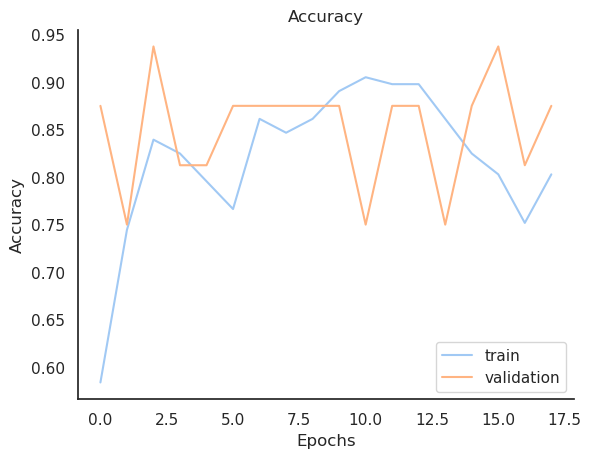

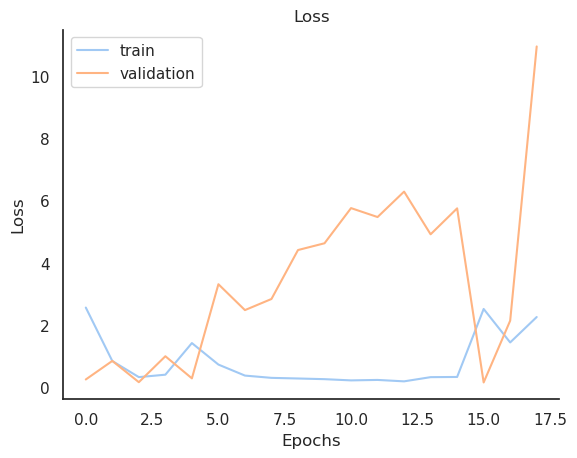

In [58]:
"""
Running the Model
"""
model, test_loss, test_acc = dnn(X_train, y_train, X_test, y_test, 1377)

In [59]:
"""
Printing accuracy and loss
"""

print(f"Test accuracy:' {test_acc}, loss: {test_loss}")

Test accuracy:' 0.8636363744735718, loss: 0.6081866899745144


At the end of training, the model ran for **21** epochs with approximately **90% accuracy** and **~25% loss**.

The training accuracy curve shows fluctuations and increases, while the validation accuracy starts high and fluctuates around **~87%**.

The training loss shows a gradual decrease, while the validation loss increases.

Given the observed curves, the model has **training difficulties** due to oscillations in the training accuracy. Note the **small dataset** and the very small validation set; more data would be required for a more complete interpretation.

### LSTM

The **LSTM** built uses an input LSTM layer that receives the total number of features and contains **1000 units**. This is followed by **3** hidden LSTM layers with **500**, **350** and **250** units respectively. The final **output** is a dense layer. Input and output layers use a **sigmoid activation**. Return sequences are enabled where used. The model was compiled using binary metrics and trained with the **Adam optimizer**.

To combat **overfitting**, Dropout layers with **20%** rate were applied after LSTM layers. ***Early Stopping*** was also used monitoring training **loss** with a patience of **5** epochs.

Validation set was **10%** of the training data.

In [60]:

def lstm(x_train, y_train, x_test, y_test):
    x_train = x_train.reshape(-1, 1, 1377)
    x_test = x_test.reshape(-1, 1, 1377)
    y_train = y_train.reshape(-1, 1, )
    y_test = y_test.reshape(-1, 1, )
    model = Sequential()
    model.add(LSTM(units=1000, input_shape=(1, 1377), activation="sigmoid", return_sequences=True))
    model.add(Dropout(0.2)) #Technique to prevent overfitting
    model.add(LSTM(units=500, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=350, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=250, return_sequences=True))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["binary_accuracy"])
    model.summary()
    es = EarlyStopping(monitor="loss", mode="min", patience=5, verbose=1)
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.1, batch_size=1, verbose=1, callbacks=[es])

    test_loss, test_acc = model.evaluate(x_test, y_test)

    # Plot Accuracy
    plt.plot(history.history["binary_accuracy"], label="train")
    plt.plot(history.history["val_binary_accuracy"], label="validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    # Plot Loss
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="validation")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Loss")
    plt.legend()
    plt.show()
    return model, test_loss, test_acc

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 1000)           9512000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1000)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 500)            3002000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 500)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 350)            1191400   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 350)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 250)           

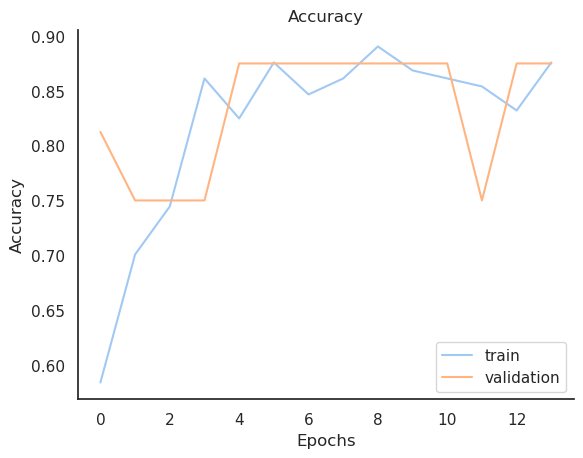

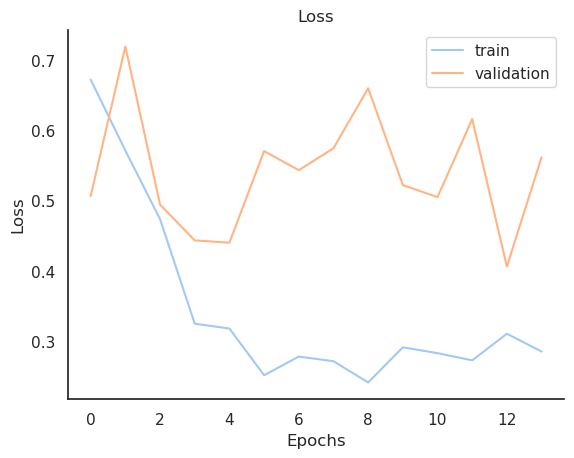

In [61]:
model, test_loss, test_acc = lstm(X_train, y_train, X_test, y_test)

In [62]:
print(f"Test accuracy:' {test_acc}, loss: {test_loss}")

Test accuracy:' 0.5925925970077515, loss: 1.8095936486215303


At the end of training, the model ran for **25** epochs with approximately **90% accuracy** and **~25% loss**.

Training accuracy increases sharply; validation accuracy stays near **~87%** with a small downward oscillation.

Training loss decreases gradually while validation loss increases.

From the curves, the model shows signs of ***overfitting*** on the training set. Again, the small dataset and tiny validation fraction limit interpretation and more data would be necessary for a robust evaluation.

### CNN

The **CNN** starts with normalization via ***Gaussian noise*** with a standard deviation of **0.05**. After shaping, a 1D convolutional layer (**Conv1D**) is applied with **8 filters** and **kernel size 32**, **ReLU activation** and **padding='same'**. A hidden Conv1D layer follows with **16 filters**. The output of convolutions is flattened, then a **Dropout(0.2)** is applied. A dense hidden layer with **128 units** (ReLU) precedes the final **sigmoid** output layer.

The model was compiled using **Adam** and binary metrics. ***Early Stopping*** (monitoring training loss) with patience **5** was used. Validation set equals **10%** of the training data.

In [63]:
g_noise = 0.05

def cnn(x_train, y_train, x_test, y_test, input_dim,g_noise, C1_K=8, C1_S=32, C2_K=16, C2_S=32):
    model = Sequential()
    model.add(GaussianNoise(g_noise, input_shape=(input_dim,)))
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K,(C1_S), activation='relu', padding="same"))
    model.add(Conv1D(C2_K, (C2_S),  activation='relu', padding="same"))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    es = EarlyStopping(monitor="loss", mode="min", patience=5, verbose=1)
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.1, batch_size=1, verbose=1, callbacks=[es])

    test_loss, test_acc = model.evaluate(x_test, y_test)

    # Plot Accuracy
    plt.plot(history.history["binary_accuracy"], label="train")
    plt.plot(history.history["val_binary_accuracy"], label="validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    # Plot Loss
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="validation")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Loss")
    plt.legend()
    plt.show()
    return cnn, test_loss, test_acc

Train on 137 samples, validate on 16 samples
Epoch 1/100
137/137 [==============================] - 2s 15ms/sample - loss: 0.6312 - binary_accuracy: 0.7299 - val_loss: 1.9369 - val_binary_accuracy: 0.5000
Epoch 2/100
137/137 [==============================] - 2s 13ms/sample - loss: 0.5599 - binary_accuracy: 0.8102 - val_loss: 0.7587 - val_binary_accuracy: 0.8750
Epoch 3/100
137/137 [==============================] - 2s 13ms/sample - loss: 0.2730 - binary_accuracy: 0.8905 - val_loss: 0.4245 - val_binary_accuracy: 0.8750
Epoch 4/100
137/137 [==============================] - 2s 15ms/sample - loss: 0.2331 - binary_accuracy: 0.9197 - val_loss: 0.8585 - val_binary_accuracy: 0.8750
Epoch 5/100
137/137 [==============================] - 2s 14ms/sample - loss: 0.2081 - binary_accuracy: 0.9051 - val_loss: 1.5726 - val_binary_accuracy: 0.8750
Epoch 6/100
137/137 [==============================] - 2s 13ms/sample - loss: 0.1887 - binary_accuracy: 0.9197 - val_loss: 1.7579 - val_binary_accuracy: 0.

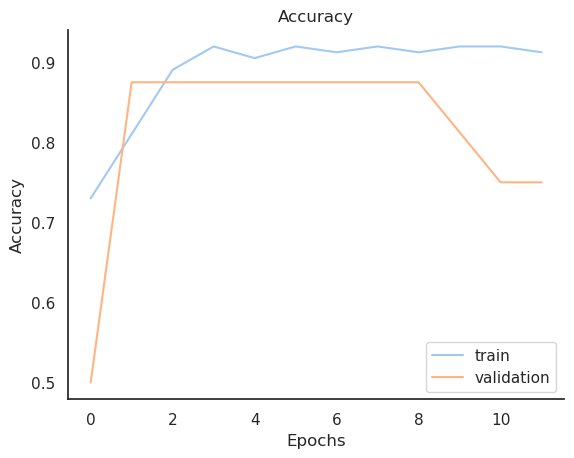

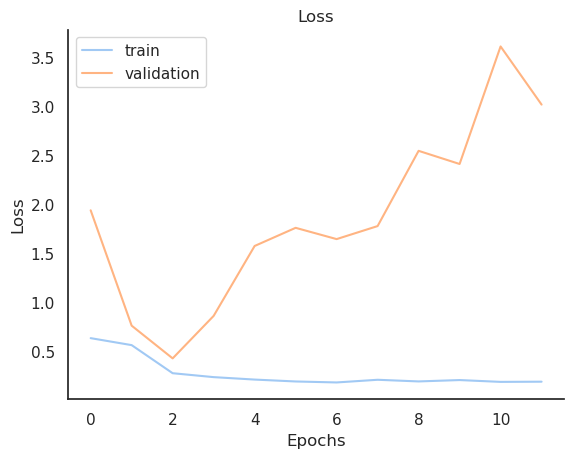

In [64]:
model, test_loss, test_acc = cnn(X_train, y_train, X_test, y_test, 1377, g_noise)

In [65]:
print(f"Test accuracy:' {test_acc}, loss: {test_loss}")

Test accuracy:' 0.8939393758773804, loss: 0.26080260041988257


At the end of training, the model ran for **17** epochs with approximately **90% accuracy** and **~24% loss**.

Training accuracy increases sharply; validation accuracy stays near **~87%** with a small downward oscillation.

Training loss decreases slightly while validation loss increases.

The model shows signs of ***overfitting*** on the training set. Again, the small dataset and tiny validation fraction limit interpretation and more data would be necessary for a robust evaluation.

### Summary

Comparing the DL methodologies tested (**DNN**, **LSTM**, **CNN**), they present similar **accuracy** values, with the **CNN** showing the **lowest loss**. All models show **overfitting** when comparing training and validation curves.

This is related to the **dimensionality and size** of the dataset. With **219 rows**, the splits create very small training/validation subsets that do not allow large-scale evaluation. A more robust evaluation would require a larger dataset.

Generally, DL models require substantially larger datasets, so we **cannot recommend DL** for this task with current data volumes. More transcriptomic data for *Oryza sativa* would be needed to build robust DL models.

## Final Remarks

During this work we extracted **gene expression data** for *Oryza sativa* from the **GEO** database. After curation and averaging replicates, we obtained a dataset with **219 rows** and **1377 columns**, corresponding to genes previously selected by *Shaik & Ramakrishna, 2014*.

From this dataset we identified which **genes** best **separated** the **biotic** and **abiotic** classes, finding two genes (**Os.17449.1.A1_at** and **Os.14745.1.S1_at**) associated with abiotic and biotic stresses respectively.

Correlation analysis revealed **strong correlations** between genes, both positive and negative, as expected in transcriptomic datasets.

Dimensionality reduction worked well, enabling 2D visualization retaining about **50%** of variance. PCA provided the clearest visual separation between classes.

Clustering (K-Means and Hierarchical) produced similar group assignments. The dendrogram gives additional information about structure at higher dimensions.

In supervised analysis, two ML models performed best: **Random Forest** and **KNN** with about **97% accuracy**. We recommend **KNN** due to lower complexity.

DL approaches showed overfitting; the best DL model (CNN) reached **~89% accuracy**, lower than ML. This may be due to transcriptomic noise and the small dataset size, limiting DL performance.

## Conclusion

Given the objective of identifying an **ML model** able to predict **biotic vs abiotic** stress from **microarray** transcriptomic data, our recommended model is **KNN**, due to its high **accuracy** and computational simplicity. DL approaches are only feasible with substantially larger datasets, which are not currently available. We therefore **recommend** increasing the volume of transcriptomic data for *Oryza sativa* to enable construction of more robust models in the future.